# Курс "Практикум по математической статистике"

# 3 курс ФПМИ МФТИ, осень 2025
## Практическое задание 1. Моделирование, оценки, свойства и сравнение.
### Дедлайн --- 27 сентября, 16:00

Это обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Сдавать ноутбук нужно будет в LMS.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.



In [433]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
# %pip install --upgrade matplotlib numpy scipy statsmodels

In [434]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [435]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as opt
import seaborn as sns

sns.set(style='darkgrid')
%matplotlib inline

In [436]:
np.random.seed(42)

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте".
Для моделирования оценки нужно:
- Сгенерировать много выборок (число можете подобрать сами, чтобы в итоге результат был репрезентативный, а ячейка считалась не дольше 5 минут)
- По каждой выборке посчитать оценку. **Указание:** считать надо не циклом, а векторными вычислениями. Вычисление циклом будет прощаться **только** если нет другого способа вычисления (исключительно редкий случай)
- Получить выборку оценок. По ней обычно бывает выгодно построить KDE, прикинуть распределение и возможно проверить его на QQ-plot, посчитать статистики распределения (дисперсию, например)

### Задача 1



В этой задаче мы будем моделировать поведение оценки медианой для распределения Лапласа с плотностью $\frac{1}{2}exp(-|x - \mu|)$.

В этой задаче Вам предстоит:
- Получить и визуализировать выборку оценок параметра $\mu$
- Построить эмпирическое приближение плотности оценки и изучить его свойства
- Проверить теоретические результаты численно и визуализировать их

1. Сделайте выборку из распределения Лапласа с параметром $\mu$ равном 9. На графике нарисуйте гистограмму выборки, плотность распределения и KDE.

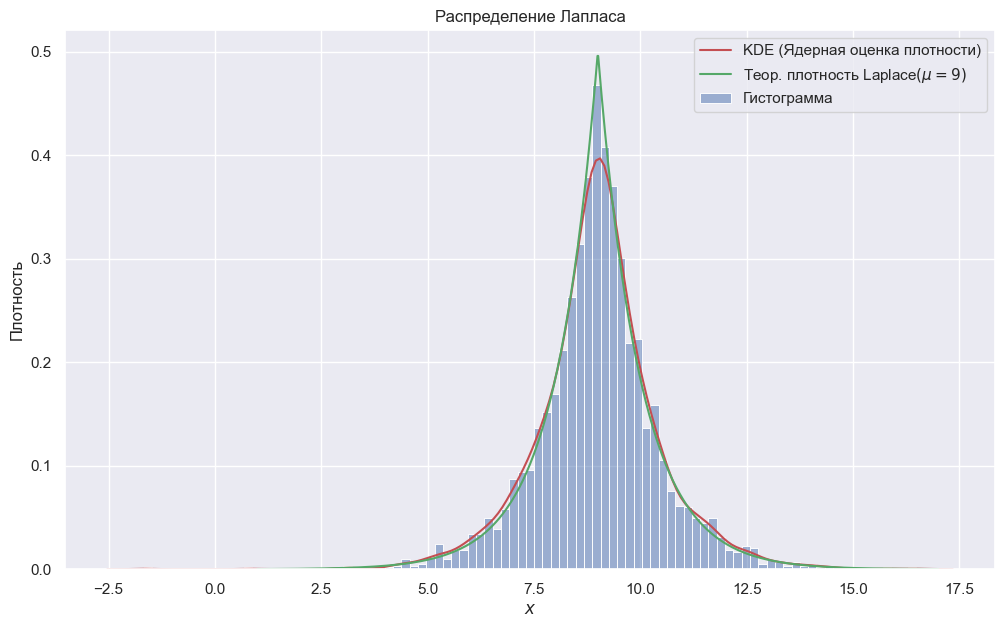

In [437]:
MU = 9.0
BETA = 1.0
SAMPLE_SIZE = 3000

sample = sps.laplace.rvs(loc=MU, scale=BETA, size=SAMPLE_SIZE)
x = np.linspace(MU - 8 * BETA, MU + 8 * BETA, 1000)
pdf_theory = sps.laplace.pdf(x, loc=MU, scale=BETA)

plt.figure(figsize=(12, 7))
sns.histplot(sample, stat="density", bins="fd", alpha=0.5, label="Гистограмма")
sns.kdeplot(sample, color="r", label="KDE (Ядерная оценка плотности)")
plt.plot(x, pdf_theory, color="g", label=r"Теор. плотность Laplace$(\mu=9)$")
plt.title("Распределение Лапласа")
plt.xlabel("$x$")
plt.ylabel("Плотность")
plt.legend()
plt.show()

Похожи ли гистограмма, KDE и теоретическая плотность? Чем KDE как приближение лучше и хуже чем гистограмма?

Да, все 3 графика похожи. Но KDE приближает чуть хуже, чем гистограмма, в силу того, что KDE это непрерывная + гладкая функция - она сглаживает особенности. Гистограмма лучше отражает данные, но на малых n будет нерепрезентативна (т.к. дискретна).

2. Сделайте выбору выборок размера 10000 на 10000. Если Вычисление застрянет, можно уменьшить до 1000 на 1000. Постройте выборку оценок. Для упрощения визуализации, посчитайте $\sqrt{N}(\hat{\mu} - \mu)$, где $N$ это размер выборки, $\hat{\mu}$ это оценка, а $\mu$ --- параметр. Визуализируйте эту выборку гистограммой и KDE

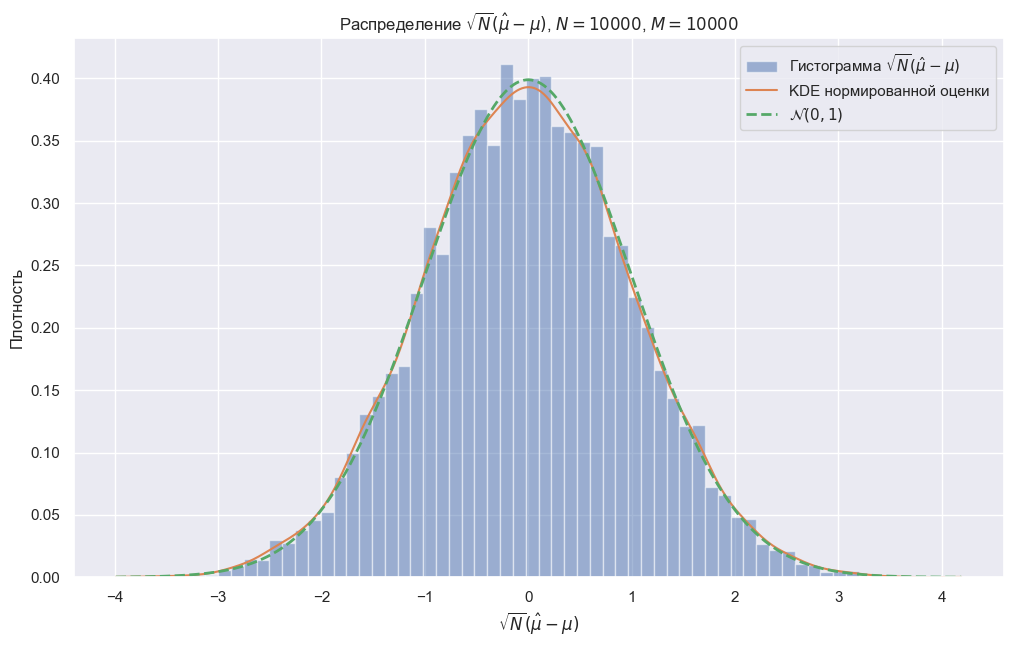

In [438]:
M = 10000
N = 10000

samples = sps.laplace.rvs(loc=MU, scale=BETA, size=(M, N))
mu_hat = np.median(samples, axis=1)
z = np.sqrt(N) * (mu_hat - MU)

x = np.linspace(z.min(), z.max(), 1000)
pdf_kde = sps.gaussian_kde(z).evaluate(x)
pdf_norm = sps.norm.pdf(x, loc=0, scale=1)

plt.figure(figsize=(12, 7))
plt.hist(z, bins='fd', density=True, alpha=0.5, label=r'Гистограмма $\sqrt{N}(\hat\mu-\mu)$')
plt.plot(x, pdf_kde, label='KDE нормированной оценки')  # это почему-то быстрее sns-го kdeplot-а
#sns.kdeplot(samples, color="r", label="KDE (Ядерная оценка плотности)") # <- крашит ide-шку
plt.plot(x, pdf_norm, linestyle='--', linewidth=2, label=r'$\mathcal{N}(0,1)$')
plt.title(r'Распределение $\sqrt{N}(\hat{\mu}-\mu)$, $N=10000$, $M=10000$')
plt.xlabel(r'$\sqrt{N}(\hat{\mu}-\mu)$')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Сделайте анализ и вывод полученного результата.

При росте N график стремится к нормальному, что соответствует ЦПТ для медианы и распределения Лапласа:
$$
\sqrt{N}(\hat\mu-\mu) \overset{d}{\longrightarrow} \mathcal{N}(0,1)
$$
Именно $\mathcal{N}(0,1)$ также наблюдается из пиковой плотности $\mathcal{N}(0,1)$ и пиковой плотности нашего графика
$$
\frac{1}{\sqrt{2\pi}}\approx 0.4.
$$
(но это немного рукомахательно, ниже более строгое рассуждение (т.к. там попросили, а тут нет))

3. Сделайте предположение о виде распределения величины $\sqrt{N}(\hat{\mu} - \mu)$ и проверьте его при помощи QQ-plot. Если сможете, объясните теоретически, почему Ваше распределение верно. Для каких случаев исходного распределения (вместо Лапласа) должно было получиться в результате такое же распределение (как у Вас)?

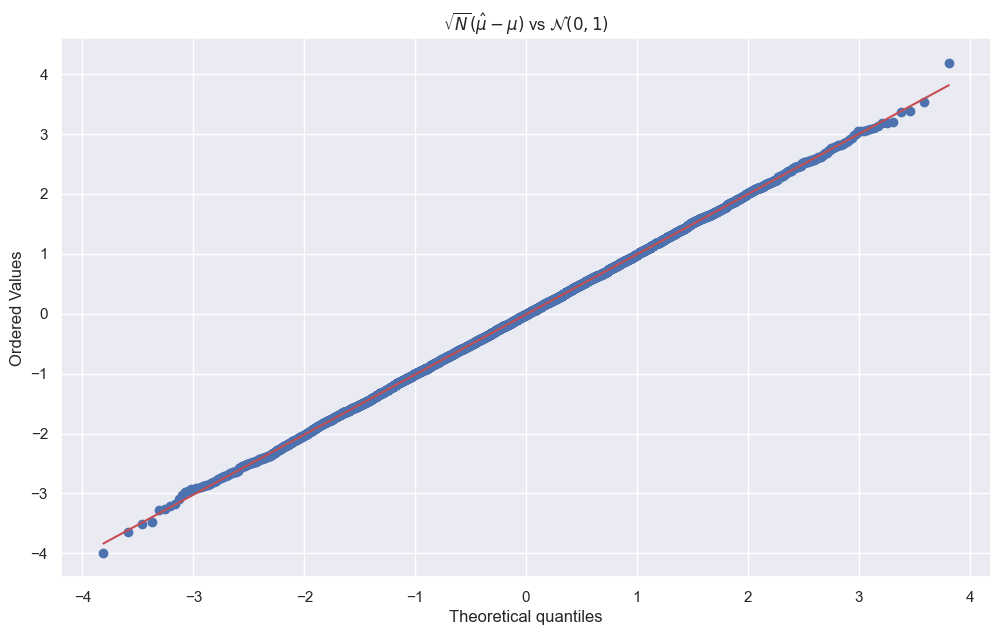

In [439]:
plt.figure(figsize=(12, 7))
_ = sps.probplot(z, dist="norm", plot=plt)
plt.title(r'$\sqrt{N}(\hat\mu-\mu)$ vs $\mathcal{N}(0,1)$')
plt.show()

В силу того, что
$$
\text{Выборочная медиана} \sim \mathcal{N}\left(\mu = m, \sigma^{2} = \frac{1}{4N p(m)^{2}}\right) \Rightarrow
$$
($\href{https://en.wikipedia.org/wiki/Median}{source}$)
$$
\Rightarrow \sqrt{N}(\hat\mu-\mu) \xrightarrow{d} \mathcal{N}\left(0,\frac{1}{4p(\mu)^{2}}\right)
$$
Поэтому результат будет верен для большого количества распределений, к $\mathcal{N}(0,1)$ будут стремиться все, с плотностью равной $\frac{1}{2}$, а в целом к нормальному будут стремиться любые распределения с н.о.р.с.в. + у которых вообще есть плотность, кроме случаев, когда есть дырки на медиане, т.е. в точке медианы плотность 0.

В нашем же случае, у распределения Лапласа плотность как раз $p(x) = \frac{1}{2}exp(-|x - \mu|) \Rightarrow p(\mu) = \frac{1}{2}$

Какие выводы можно сделать, если точки в хвостах QQ-plot находятся выше/ниже своей прямой, как на картинке ниже? А если оба "хвоста" находятся с одной стороны прямой?


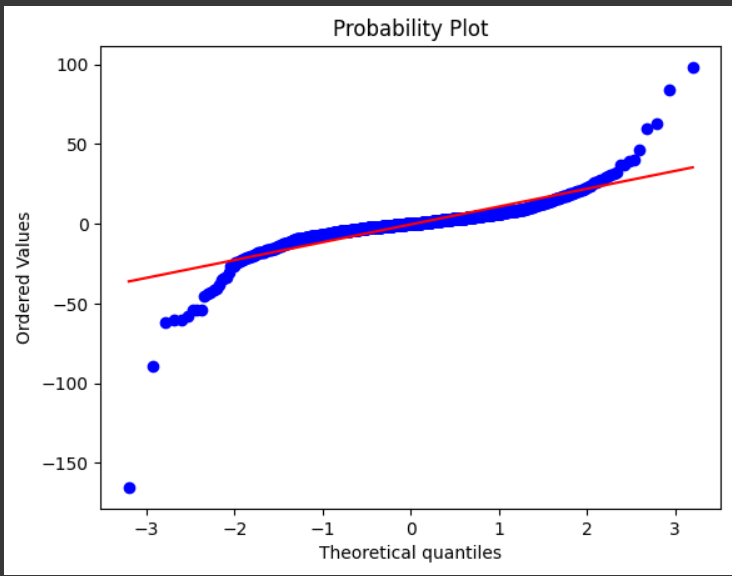

**Ответ:**

По картинке можно сделать вывод, что распределение симметрично, квантили в хвостах тяжелее теоретических, что обычно указывает на бОльшую массы у нуля, в обратном же случае были бы более легкие хвосты и меньше массы у нуля. Если бы хвосты были с одной стороны прямой, то это бы означало асимметрию и скошенность вправо (оба выше линии) / лево (оба ниже линии)

4. Изучите, сходится ли оценка $\hat{\mu}$ к чему-то по вероятности с ростом N? Опишите, какой график Вы построите, чтобы это проверить и какие численные характеристики посчитаете для этого.

Оценка сходится по вероятности, если она состоятельна.
Ну а это значит, что:
$$\forall \varepsilon > 0 P(||\widehat{\theta}_n - \theta|| > \varepsilon) \xrightarrow{n \to \infty} 0$$
(в нашем случае $\mu := \theta$)

Для того, чтобы показать состоятельность построим график медиан: рисуем $N$ траекторий $\hat\mu_N$ от 1 до $\text{MAX\_N}$ и накладываем $\varepsilon$-трубку $[\mu-\varepsilon,\mu+\varepsilon]$. При состоятельности график сжимается и траектории остаются внутри трубки.

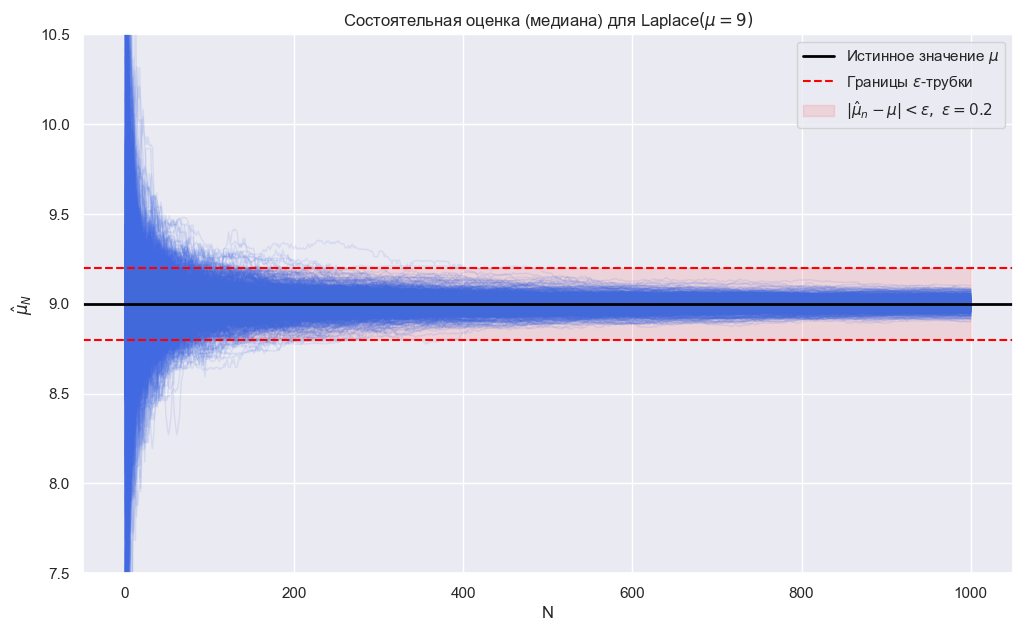

In [440]:
EPSILON = 0.2
MAX_N = 1000
N_TRAJECTORIES = 1000
M_REPS = 4000

trajectories_data = sps.laplace.rvs(loc=MU, scale=BETA, size=(N_TRAJECTORIES, MAX_N))
N_RANGE = np.arange(1, MAX_N + 1)

median_estimates = np.empty((N_TRAJECTORIES, MAX_N))
for n in range(1, MAX_N + 1):
    median_estimates[:, n - 1] = np.median(trajectories_data[:, :n], axis=1)

plt.figure(figsize=(12, 7))
plt.title(r'Состоятельная оценка (медиана) для Laplace$(\mu=9)$')
plt.plot(N_RANGE, median_estimates.T, color='royalblue', alpha=0.12, linewidth=1)
plt.axhline(MU, color='black', lw=2, label=r'Истинное значение $\mu$')
plt.axhline(MU + EPSILON, color='red', ls='--', lw=1.5, label=r'Границы $\varepsilon$-трубки')
plt.axhline(MU - EPSILON, color='red', ls='--', lw=1.5)
plt.fill_between(N_RANGE, MU - EPSILON, MU + EPSILON, color='red', alpha=0.10,
                 label=rf'$|\hat\mu_n-\mu|<\varepsilon,\ \varepsilon={EPSILON}$')
plt.xlabel('N')
plt.ylabel(r'$\hat\mu_N$')
plt.ylim(MU - 1.5, MU + 1.5)
plt.legend()
plt.show()

На практике статисты не отличают состоятельность от сильной состоятельности (сходимость по вероятности и почти наверное) и проверяют оба свойства одинаково. Годится ли наш метод практической проверки для проверки сильной состоятельности? Как можно было бы проверить её качественнее?

**Ответ**:

Сам по себе такой подход не доказывает (!) сильной состоятельности: мы смотрим распределение при каждом $n$, а не поведение одной траектории на бесконечности.

Но данный график уже неплохое эмпирическое (!) свидетельство сильной состоятельности.
Ещё можно для каждой кривой $i$, на сетке $N_0$-ей ввести $sup_{N\in[N_0,N_{\max}]}|\hat\mu_N^{(i)}-\mu|$, эта величина (с ростом $N_0$) должна стремится к нулю (а чтобы агрегировать траекториями взять, например, медиану или квантили). Это наблюдение по крайней мере чуть более качественное свидетельство сильной состоятельности, так мы прослеживаем не каждое $N$, а $N \ge N_0$.


5. Посчитайте среднее и выборочную дисперсию оценки для разных N. Как они ведут себя в пределе?

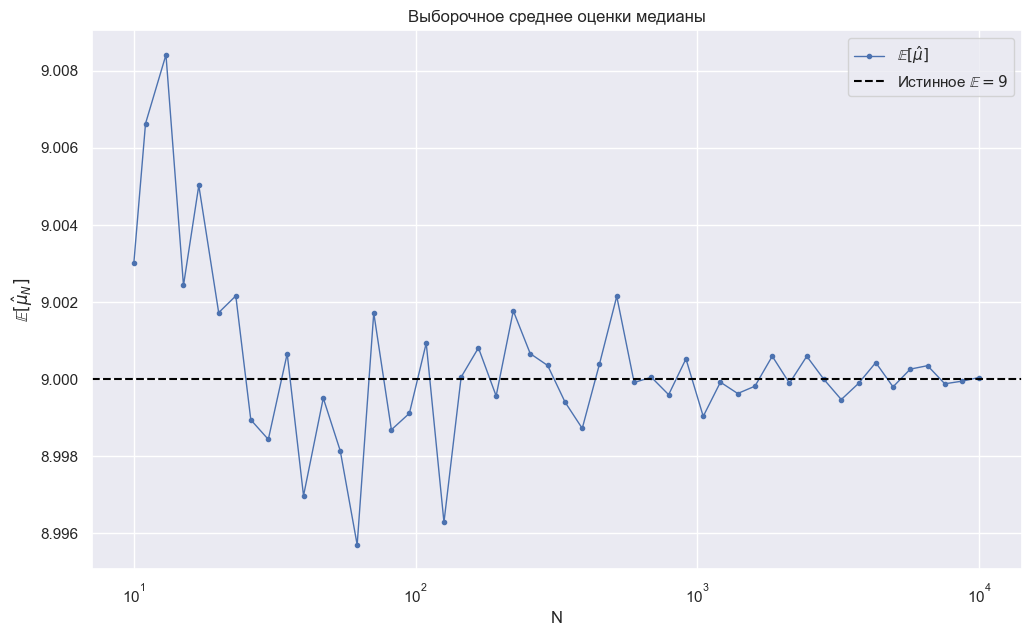

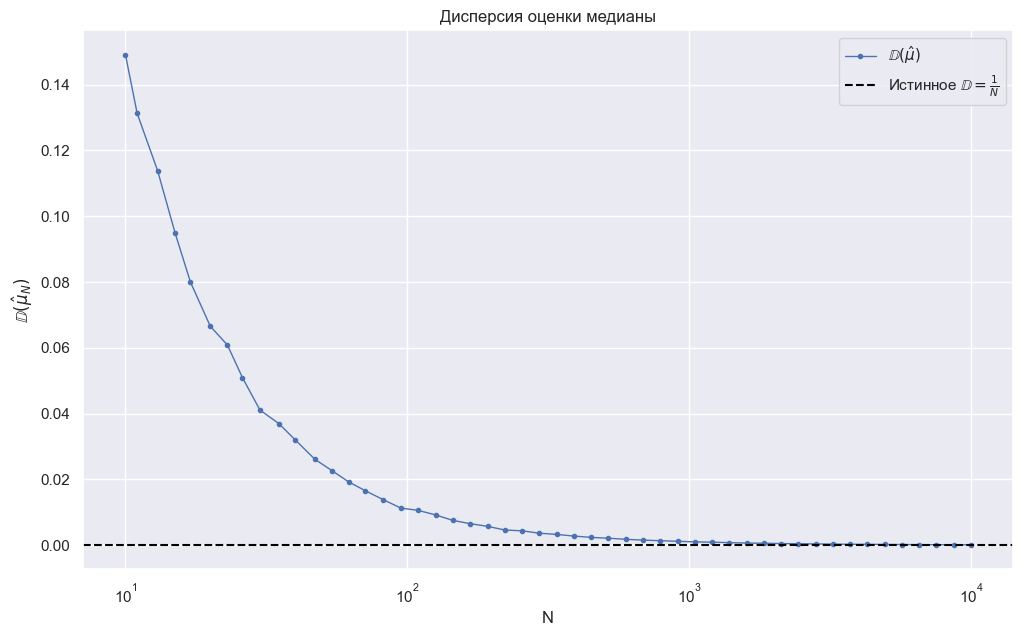

In [441]:
means = []
vars_ = []
N_GRID = np.unique(np.geomspace(10, 10000, 50).astype(int))

for N in N_GRID:
    samples = sps.laplace.rvs(loc=MU, scale=BETA, size=(M_REPS, N))
    mu_hat = np.median(samples, axis=1)
    means.append(mu_hat.mean())
    vars_.append(mu_hat.var(ddof=0))

means = np.array(means)
vars_ = np.array(vars_)

plt.figure(figsize=(12, 7))
plt.plot(N_GRID, means, marker='o', ms=3, lw=1, label=r'$\mathbb{E}[\hat\mu]$')
plt.axhline(MU, ls='--', lw=1.5, color='black', label=r'Истинное $\mathbb{E}=9$')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel(r'$\mathbb{E}[\hat\mu_N]$')
plt.title(r'Выборочное среднее оценки медианы')
plt.legend()
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(N_GRID, vars_, marker='o', ms=3, lw=1, label=r'$\mathbb{D}(\hat\mu)$')
plt.axhline(0, ls='--', lw=1.5, color='black', label=r'Истинное $\mathbb{D}=\frac{1}{N}$')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel(r'$\mathbb{D}(\hat\mu_N)$')
plt.title(r'Дисперсия оценки медианы')
plt.legend()
plt.show()

Графики подтверждают ЗБЧ: при росте $N$ выборочные дисперсия и среднее стремятся к своим теоретическим значениям.

Дисперсия стремится со скоростью $\frac{1}{N}$, что соотносится с
$$
\mathbb{D}(\hat\mu_N) \sim \frac{1}{4N p(\mu)^2}
$$
(source: см. п.3)

6. Постройте KDE величины $\sqrt{N}(\hat{\mu} - \mu)$ для разных $N$. Можно ли говорить о равномерной сходимости их к какой-то функции? Что это за функция?

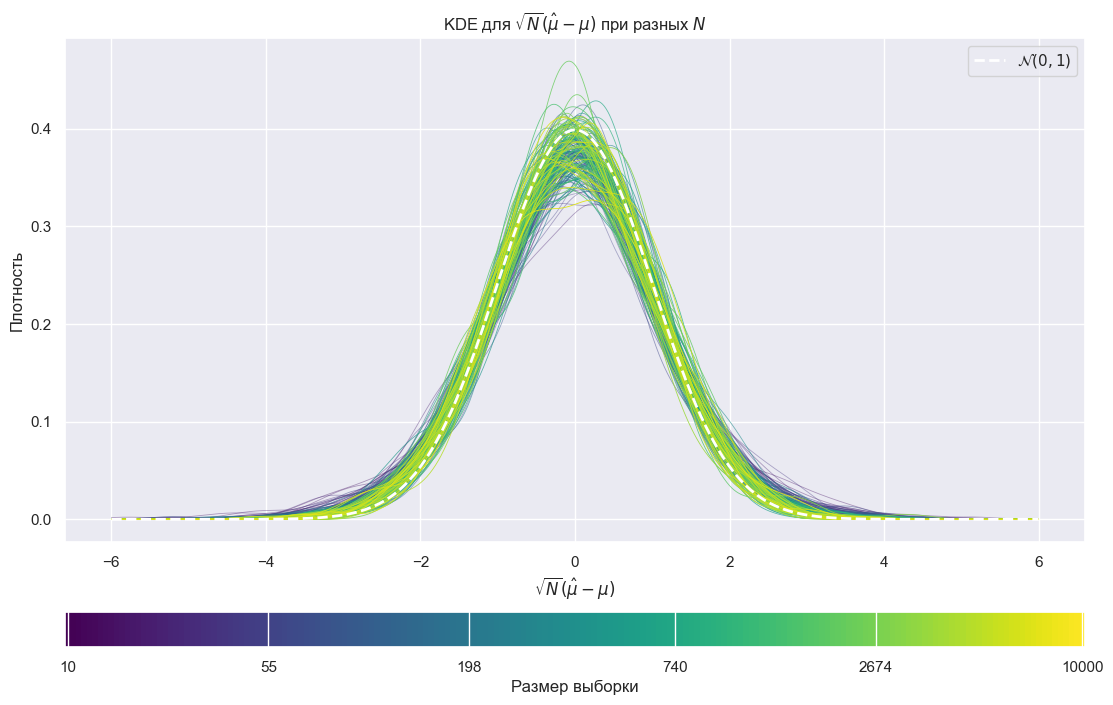

In [442]:
M_REPS = 500
N_LIST = np.unique(np.round(np.geomspace(10, 10000, 200)).astype(int))
x = np.linspace(-6, 6, 1000)

cmap = plt.colormaps['viridis']
colors = cmap(np.linspace(0.05, 0.95, len(N_LIST)))

fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0.10, 0.20, 0.85, 0.72])
helper = 2000
alpha = 0.4
sz = len(N_LIST) // 6
sz_copy = sz
for i, c, N in zip(range(len(N_LIST)), colors, N_LIST):
    if i > sz:
        sz += sz_copy
        alpha += 0.1
    samples = sps.laplace.rvs(loc=MU, scale=BETA, size=(M_REPS, N))
    mu_hat = np.median(samples, axis=1)
    z = np.sqrt(N) * (mu_hat - MU)
    kde = sps.gaussian_kde(z)
    ax.plot(x, kde(x), color=c, alpha=alpha, lw=0.6)

phi = sps.norm.pdf(x)
ax.plot(x, phi, '--', lw=2, color='white', label=r'$\mathcal{N}(0,1)$')
ax.set_title(r'KDE для $\sqrt{N}(\hat{\mu}-\mu)$ при разных $N$')
ax.set_xlabel(r'$\sqrt{N}(\hat{\mu}-\mu)$')
ax.set_ylabel('Плотность')
ax.legend()

axg = fig.add_axes([0.10, 0.05, 0.85, 0.05])
grad = np.linspace(0, 1, len(N_LIST))[None, :]
axg.imshow(grad, aspect='auto', cmap='viridis', origin='lower')
axg.set_yticks([])
tick_idx = np.linspace(0, len(N_LIST) - 1, 6).astype(int)
axg.set_xticks(tick_idx)
axg.set_xticklabels([str(N_LIST[i]) for i in tick_idx])
axg.set_xlabel('Размер выборки')
plt.show()

На графике видно, что, при увеличении N, KDE сходится к функции с нормальным распределением (желтые и зеленые траектории при больших N), в нашем случае $\mathcal{N}(0,1)$, что подтверждает ЦПТ и рассуждения выше.
Ещё можно эмпирически установить, что эта сходимость равномерная (переход от холодных цветов к теплым - кривые *равномерно* сужаются) на компакте (вообще говоря, на всей прямой это может быть не так, но в нашем случае всё хорошо, т.к. мы знаем распределение - это легко доказать).

### Задача 2



В этой задаче мы будем работать с известной оценкой высокого качества --- Оценкой Максимального Правдоподобия (ОМП).

В этой задаче Вам предстоит:
- Записать правдоподобие как функцию для оптимизации
- Численно при помощи градиентного спуска найти оценку
- Изучить её предельное поведение

**В данной задаче разрешается не писать метод Ньютона и градиентный спуск руками, а пользоваться scipy.optimize**.

Правдоподобие выборки из непрерывного распределения это произведение плотностей её элементов (правдоподобие данной выборки --- функция, зависящая только от параметров распределения). Оценка максимального правдоподобия --- такое значение параметра, при котором правдоподобие максимально.

1. Выпишите функцию правдоподобия выборки из $N$ элементов. Какому уравнению удовлетворяет оценка (как максимум этой функции)? Глядя на получившуюся формулу объясните, в чём основной недостаток оценки ОМП, если выборка состоит из большого числа элементов?

**Ответ:**

Функция правдоподобия:
$$
f_{\theta}(X)=f_{\theta}(X_1,\ldots,X_N)=p_{\theta}(X_1)\cdots p_{\theta}(X_N)=\prod_{i=1}^{N} p_{\theta}(X_i)
$$

Оценка максимального правдоподобия:
$$
\hat{\theta}_{MP}(X_1,\ldots,X_N)=\arg\max_{\theta\in\Theta} f_{\theta}(X_1,\ldots,X_N)
$$

Уравнение для ОМП:
$$
\frac{\partial f}{\partial\theta}(\hat{\theta}_{MP})=0
$$

Главная проблема: так как $p_{\theta}(X_i)$ - плотность, то при перемножении большого количества элементов $< 1$ (чаще всего), получаются очень маленькие числа, которые сложно сравнивать. И наоборот, если плотности $> 1$, получаются слишком большие числа.

2. Сгенерируйте выборку из распределения Коши с параметром сдвига 9 из 100 элементов.

Градиентный спуск это алгоритм поиска минимума функции, который "шагает" по минус градиенту (антиградиенту), пока тот не обнулится. Этот алгоритм имеет смысл, так как градиент указывает в сторону возрастания функции.

Попробуйте выписать производную функции правдоподобия для выборки из 100 элементов. Если у Вас это получилось, подайте эту производную в функцию scipy.optimize.minimize и посмотрите, какой результат эта функция Вам предложит.

Найдём производную по $\theta$ для распределения Коши:
$$
p_{\theta}(x)=\frac{1}{\pi}\cdot\frac{1}{1+(x-\theta)^2}.
$$
$$
\frac{\partial}{\partial\theta}p_{\theta}(X_i)
=\frac{1}{\pi}\cdot\frac{2(X_i-\theta)}{\bigl(1+(X_i-\theta)^2\bigr)^2}.
$$
$$
\frac{\partial}{\partial\theta} f_{\theta}(X)
=\sum_{i=1}^{n}\Biggl(\prod_{j\neq i} p_{\theta}(X_j)\Biggr)
\frac{\partial}{\partial\theta} p_{\theta}(X_i)
$$
$$
\frac{\partial}{\partial\theta} f_{\theta}(X)
= \sum_{i=1}^{n}\frac{\prod_{i=1}^{n} p_{\theta}(X_i)}{p_{\theta}(X_i)} p'_{\theta}(X_i)
= f_{\theta}(X)\sum_{i=1}^{n}\frac{2(X_i-\theta)}{1+(X_i-\theta)^2}
$$

In [443]:
N = 100
LOC_TRUE = 9.0
SCALE = 1.0

x = sps.cauchy.rvs(loc=LOC_TRUE, scale=SCALE, size=N)


def likelihood(theta):
    return -np.prod((1 / np.pi) / (1 + (x - theta) ** 2))


def grad_likelihood(theta):
    L = likelihood(theta)
    sum_ = np.sum(2 * (x - theta) / (1 + (x - theta) ** 2))
    dL = L * sum_
    return -dL


res = opt.minimize(
    fun=likelihood,
    x0=20,
    jac=grad_likelihood,
    options=dict(gtol=1e-6, disp=True)
)

print("ОМП:", res.x)
print("Значение f:", res.fun)
print("Значение градиента:", res.jac)
print("Статус:", res.message)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
ОМП: [20.]
Значение f: -1.945912984902814e-255
Значение градиента: [-3.63447707e-254]
Статус: Optimization terminated successfully.


Если у Вас всё почему-то сломалось, объясните почему.

**Ответ:**

Оптимизатор завершил работу за первый же подсчёт градиента и выдал за ответ стартовую точку (не сделав по факту ни одной итерации), что неудивительно, при $N = 100$, функция уже $f_{\theta}(X) \approx 10^{-100}$, а её градиет ещё меньше, так что выполнился критерий остановки, т.к. для оптимизатора это всё равно, что 0, так что мы "достигли минимума".

3. Вместо максимизации правоподобия статисты минимизируют минус логарифм правдоподобия (называя его логправдоподобием). Объясните, чем это лучше.

Посчитайте производную минус логарифма правдоподобия и подайте её снова в scipy.optimize.minimize. Предложите хорошую стартовую точку для метода? Как Вам кажется, какая оценка параметра сдвига может быть хорошим стартом для поиска ОМП?

Логарифмическая функция правдоподобия:
$$
L_{\theta}(X_1,\ldots,X_n)=\ln f_{\theta}(X_1,\ldots,X_n)
=\sum_{i=1}^{n}\ln p_{\theta}(X_i).
$$
(Благо в этот раз производная считается тривиально, устно и классно)

In [444]:
def ln_likelihood(theta):
    return -np.sum(-np.log(np.pi) - np.log(1 + (x - theta) ** 2))


def grad_ln_likelihood(theta):
    return np.sum(2 * (theta - x) / (1 + (x - theta) ** 2))


res_bad_start = opt.minimize(
    fun=ln_likelihood,
    x0=52,
    jac=grad_ln_likelihood,
    options=dict(gtol=1e-6, disp=True)
)

res = opt.minimize(
    fun=ln_likelihood,
    x0=np.median(x),
    jac=grad_ln_likelihood,
    options=dict(gtol=1e-6, disp=True)
)

print("ОМП:", res.x)
print("ОМП с плохим стартом (для наглядности):", res_bad_start.x)
print("Значение -L$:", res.fun)
print("Значение градиента:", res.jac)
print("Статус:", res.message)

Optimization terminated successfully.
         Current function value: 248.957171
         Iterations: 3
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 248.957171
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
ОМП: [9.03855948]
ОМП с плохим стартом (для наглядности): [9.03855948]
Значение -L$: 248.95717147803737
Значение градиента: [-2.56082111e-07]
Статус: Optimization terminated successfully.


**Ответы на вопросы:**

Логправдоподие лучше по ряду причин, но самая главная - оно устраняет главный недостаток обычной функции правдоподобия: $\prod_i p_\theta(x_i)$ превращается в сумму $\sum_i \log p_\theta(x_i)$, при этом максимум $f_{\theta}$ эквивалентен минимуму $-L_{\theta}$.

Хорошей точкой старта будет выборочная медиана, так как на больших N она будет примерна равна истинной оценке и не очень чувствительная к выбросам относительно, например, выборочного среднего.

*Note*: В прошлом пункте, когда оптимизатор ломался, он выдавал оценку равной точке старта, поэтому могло показаться, что в прошлом пункте ответ получался правильный если выбрать медиану (поэтому там сейчас тоже плохая точка старта). Для наглядности добавил ОМП с плохой точкой старта градиентного спуска, чтобы было видно, что алгоритм сам отработал корректно, а не мы просто предоставили ему близкую точку старта.



4. Найдите ОМП для размеров выборки от 10 до 1000 с какой-то сеткой. Изобразите их на графике. Сходятся ли они к чему-то?

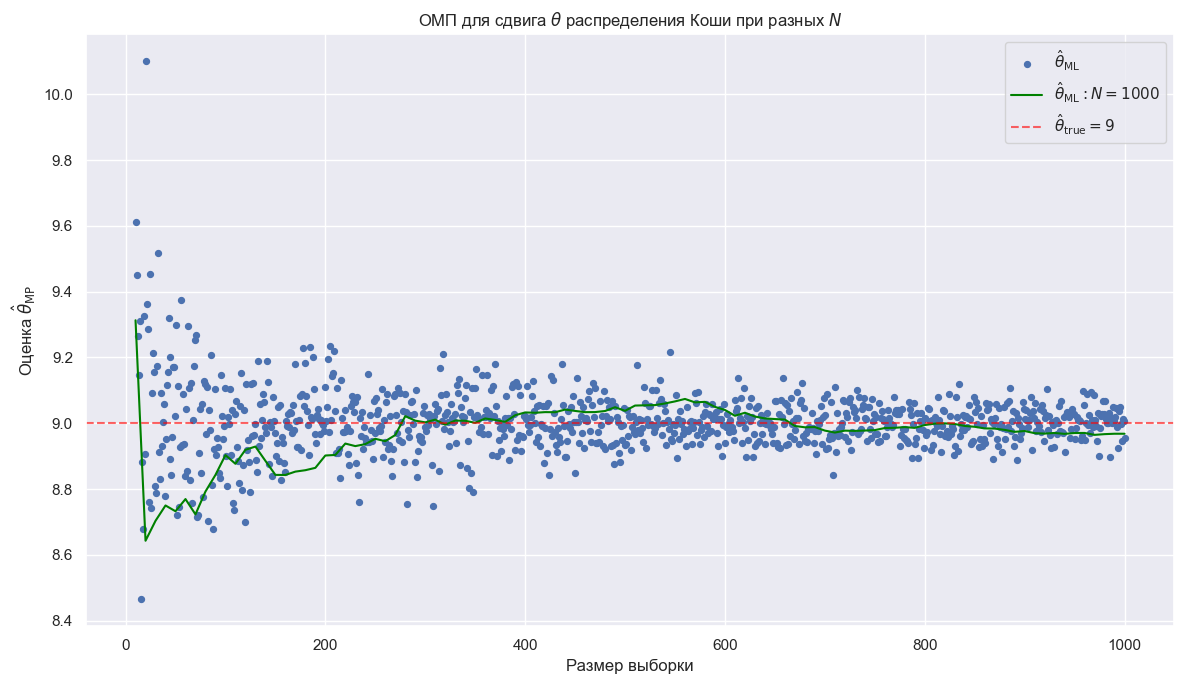

In [445]:
N_LIST = range(10, 1001)
N_LIST_10 = range(10, 1001, 10)
N = 1000
thetas = []
thetas_10 = []
np.random.seed(42)  # <- перестраховка: N - маловат, поэтому некоторые генерации сходятся не так явно
big_x = sps.cauchy.rvs(loc=LOC_TRUE, scale=SCALE, size=N)

for N in N_LIST:
    x = sps.cauchy.rvs(loc=LOC_TRUE, scale=SCALE, size=N)
    res = opt.minimize(
        fun=ln_likelihood,
        x0=np.median(x),
        jac=grad_ln_likelihood,
        options=dict(gtol=1e-6)
    )
    thetas.append(res.x)
    if N % 10 == 0:
        x = big_x[:N]
        res = opt.minimize(
            fun=ln_likelihood,
            x0=np.median(x),
            jac=grad_ln_likelihood,
            options=dict(gtol=1e-6)
        )
        thetas_10.append(res.x)

plt.figure(figsize=(12, 7))
plt.scatter(N_LIST, thetas, s=18, label=r'$\hat{\theta}_{\mathrm{ML}}$')
plt.plot(N_LIST_10, thetas_10, color="green", label=r'$\hat{\theta}_{\mathrm{ML}}: N = 1000$')
plt.axhline(LOC_TRUE, color="red", alpha=0.6, linestyle='--', label=r'$\hat{\theta}_{\mathrm{true}} = 9$')
plt.title(r'ОМП для сдвига $\theta$ распределения Коши при разных $N$')
plt.xlabel(r'Размер выборки')
plt.ylabel(r'Оценка $\hat{\theta}_{\mathrm{MP}}$')
plt.tight_layout()
plt.legend()
plt.show()

Видно, что, с ростом N, ОМП стремится к истинному параметру сдвига и довольно близок к нему, что подтверждает теорию. Также, для наглядности взял префиксы выборки N = 1000.

Осцилляции ОМП также в пределах асимптотической дисперсии, но чтобы это утверждать её нужно посчитать, ~~т.е. затехать, а нас об этом не просят~~ в следующем пункте посчитано.

5. Для $N = 1000$ изобразите KDE и/или QQ-plot величины $\sqrt{N}(\hat{\theta} - \theta)$ и выясните, к какому предельному распределению оно сходится.

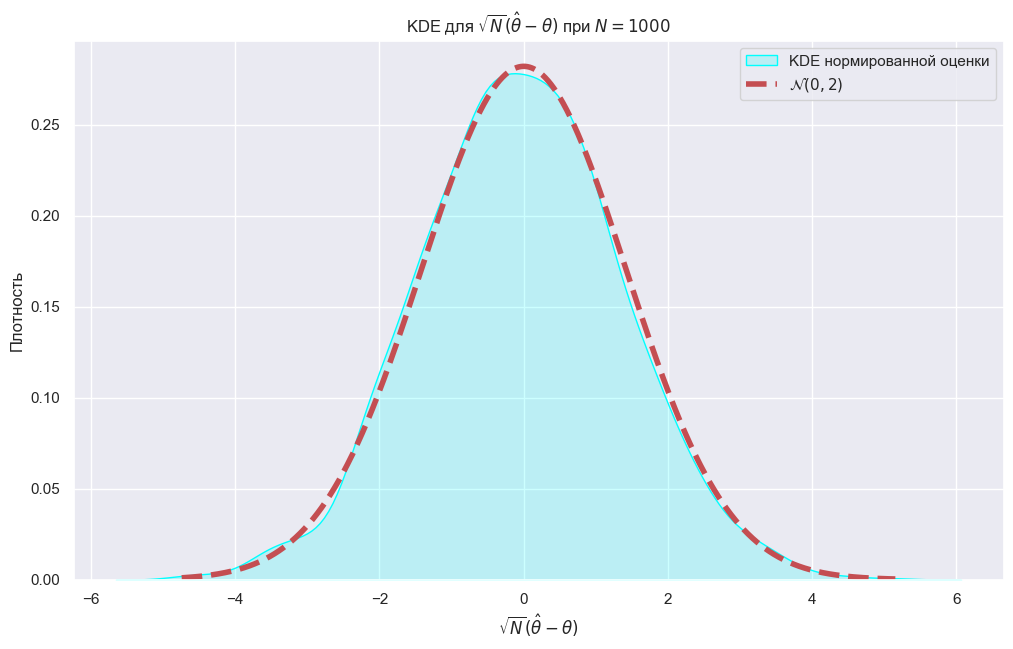

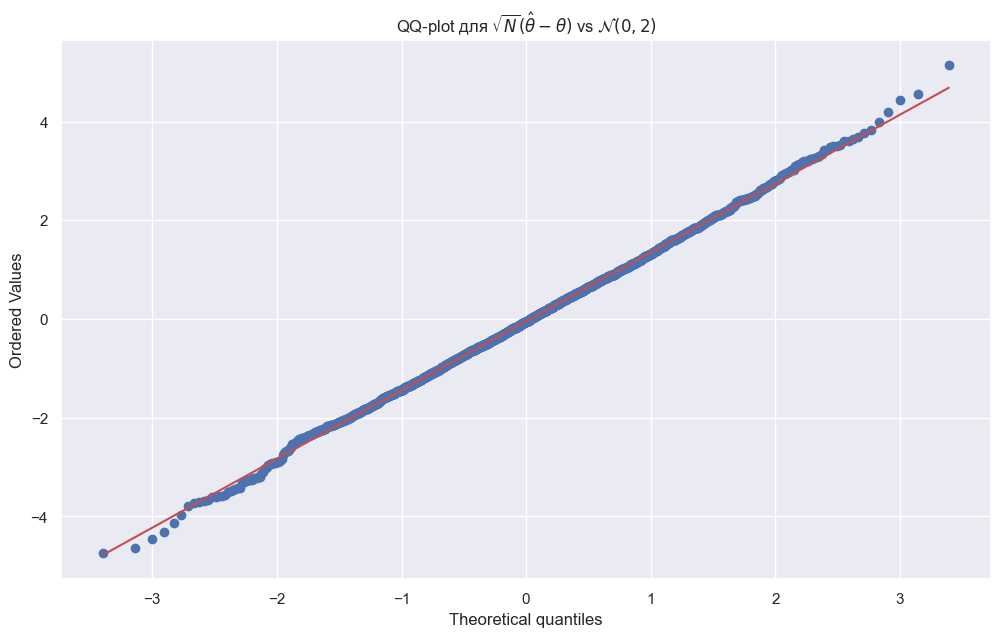

In [446]:
M_REPS = 2000
thetas = []
for m in range(M_REPS):
    x = sps.cauchy.rvs(loc=LOC_TRUE, scale=SCALE, size=N)
    res = opt.minimize(
        fun=ln_likelihood,
        x0=np.median(x),
        jac=grad_ln_likelihood,
        options=dict(gtol=1e-6)
    )
    thetas.append(np.sqrt(N) * (res.x - LOC_TRUE))
thetas = np.array(thetas).ravel()

x_grid = np.linspace(thetas.min(), thetas.max(), 1000)
#pdf_kde = sps.gaussian_kde(thetas).evaluate(x_grid)
pdf_norm = sps.norm.pdf(x_grid, loc=0, scale=np.sqrt(2))

plt.figure(figsize=(12, 7))
sns.kdeplot(thetas, fill=True, color="cyan", alpha=0.2, label='KDE нормированной оценки')
#plt.plot(x_grid, pdf_kde, color="g", label='KDE нормированной оценки')
plt.plot(x_grid, pdf_norm, '--', color="r", lw=4, label=r'$\mathcal{N}(0, 2)$')
plt.title(r'KDE для $\sqrt{N}(\hat{\theta}-\theta)$ при $N=1000$')
plt.xlabel(r'$\sqrt{N}(\hat{\theta}-\theta)$')
plt.ylabel('Плотность')
plt.legend()
plt.show()

plt.figure(figsize=(12, 7))
sps.probplot(thetas, dist="norm", plot=plt)
plt.title(r'QQ-plot для $\sqrt{N}(\hat{\theta}-\theta)$ vs $\mathcal{N}(0,2)$')
plt.show()

KDE для $\sqrt{N}(\hat\theta-\theta)$ сходится к $\mathcal N(0,2)$, что, опять же, подтверждает теория:
$$
\sqrt{N}(\hat\theta_{\text{MP}}-\theta)\ \xrightarrow{d}\ \mathcal{N}(0, i(\theta)^{-1}),
$$
$$
i(\theta)=\mathbb E\!\left[\frac{4(X-\theta)^2}{(1+(X-\theta)^2)^2}\right]=[z = X-\theta]=
\frac{4}{\pi}\int_{-\infty}^{\infty}\frac{z^2}{(1+z^2)^3}dz=[\href{https://prnt.sc/lo3sa5xajq8J}{\text{Нет. А, это бета функция}}]=\frac12 \Rightarrow
$$

$$
\Rightarrow \sqrt{N}(\hat\theta_{\text{MP}}-\theta)\ \xrightarrow{d}\ \mathcal{N}(0,2)
$$

Интересный момент в том, что само распределение Коши не может сходиться к нормальному, так как у него не существует математического ожидания и дисперсии, но ОМП может, для него есть формула выше.

(QQ-plot подтверждает эти выводы ещё раз)

### Задача 3

В этой задаче мы изучим способы сравнения оценок между собой.

Мы будем оценивать параметр $\theta$ распределения $U[0, \theta]$ следующими способами: $2\overline{X}$, $\frac{n+1}{n} X_{(n)}$, $(n+1)X_{(1)}$, $\overline{X} + X_{(n)}/ 2$ и $X_{(1)}+X_{(n)}$. Зафиксируем конкретное значение параметра $\theta = 9$.

В этой задаче Вам предстоит:
- Промоделировать и сравнить все предложенные оценки
- Посчитать численный риск и убедиться, что это разумная метрика качества оценки
- Применить равномерный и байесовский подходы к сравнению оценок

1. Промоделируйте каждую из оценок. Постройте все оценки на графике в единых осях или на таблице графиков с общими осями. Если будут расхождения в масштабах, ниже постройте отдельные графики для оценок с разными подходящими масштабами.

In [447]:
def plot_hist_kde(data, axes, label):
    sns.histplot(
        data, bins=120, kde=True, stat='density', ax=axes, label=label, element='step', alpha=0.3
    )

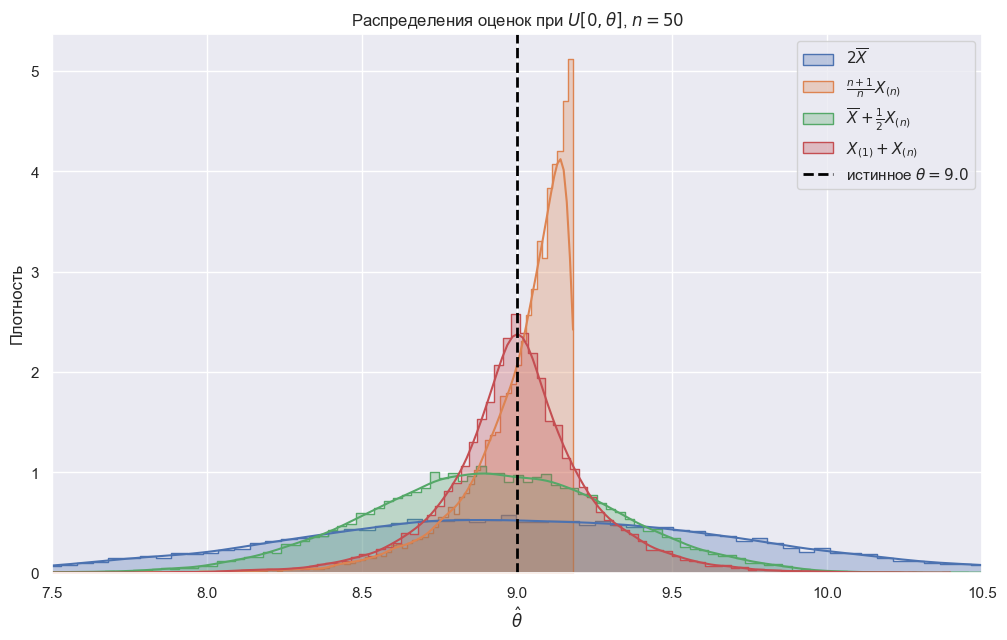

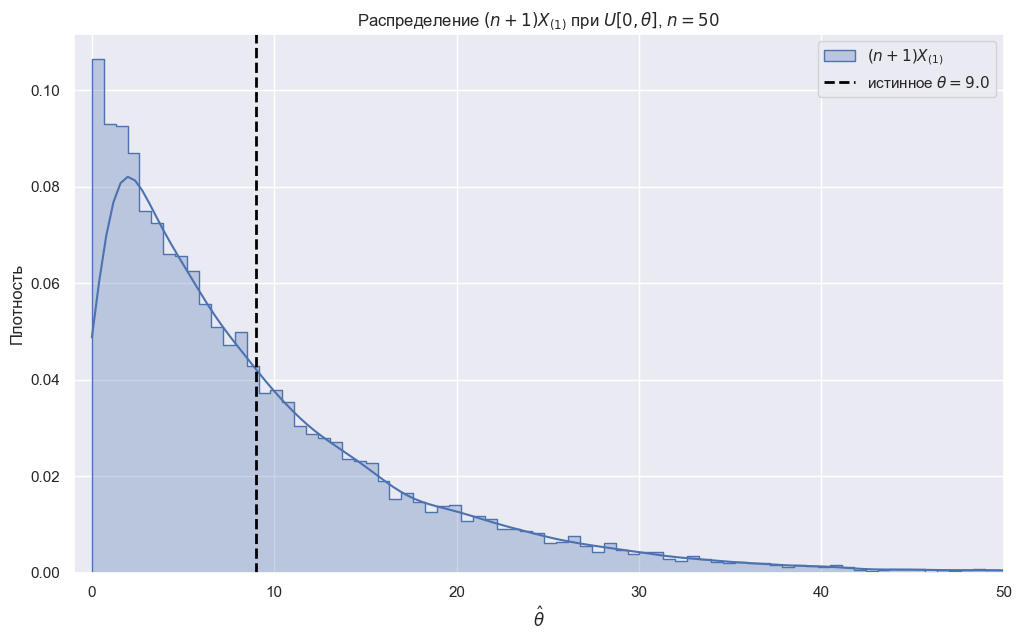

In [448]:
THETA = 9.0
N = 50
M_REPS = 20000

samples = sps.uniform(scale=THETA).rvs(size=(M_REPS, N))

xbar = samples.mean(axis=1)
xmin = samples.min(axis=1)
xmax = samples.max(axis=1)

theta_hat = {
    r'$2\overline{X}$': 2.0 * xbar,
    r'$\frac{n+1}{n}X_{(n)}$': ((N + 1) / N) * xmax,
    r'$(n+1)X_{(1)}$': (N + 1) * xmin,
    r'$\overline{X} + \frac{1}{2}X_{(n)}$': xbar + 0.5 * xmax,
    r'$X_{(1)} + X_{(n)}$': xmin + xmax,
}

_, ax1 = plt.subplots(figsize=(12, 7))
good_keys = [k for k in theta_hat.keys() if k != r'$(n+1)X_{(1)}$']
for k in good_keys:
    plot_hist_kde(theta_hat[k], ax1, label=k)
ax1.axvline(THETA, color='black', lw=2, ls='--', label=rf'истинное $\theta={THETA}$')
ax1.set_xlim(THETA - 1.5, THETA + 1.5)
ax1.set_title(rf'Распределения оценок при $U[0,\theta]$, $n={N}$')
ax1.set_xlabel(r'$\hat{\theta}$')
ax1.set_ylabel('Плотность')
ax1.legend()
plt.show()

_, ax2 = plt.subplots(figsize=(12, 7))
plot_hist_kde(theta_hat[r'$(n+1)X_{(1)}$'], ax2, label=r'$(n+1)X_{(1)}$')
ax2.axvline(THETA, color='black', lw=2, ls='--', label=rf'истинное $\theta={THETA}$')
ax2.set_xlim(-1, 50)
ax2.set_title(rf'Распределение $(n+1)X_{{(1)}}$ при $U[0,\theta]$, $n={N}$')
ax2.set_xlabel(r'$\hat{\theta}$')
ax2.set_ylabel('Плотность')
ax2.legend()
plt.show()

У $(n+1)X_{(1)}$ сильно другой масштаб, поэтому она отдельно.

2. Изучите, как меняются распределения оценок с изменением размера выборки. Для этого постройте KDE для 4-5 разных размеров на одном графике. Для каждой оценки сделайте отдельный такой график. Сделайте выводы о предельном поведении оценок.

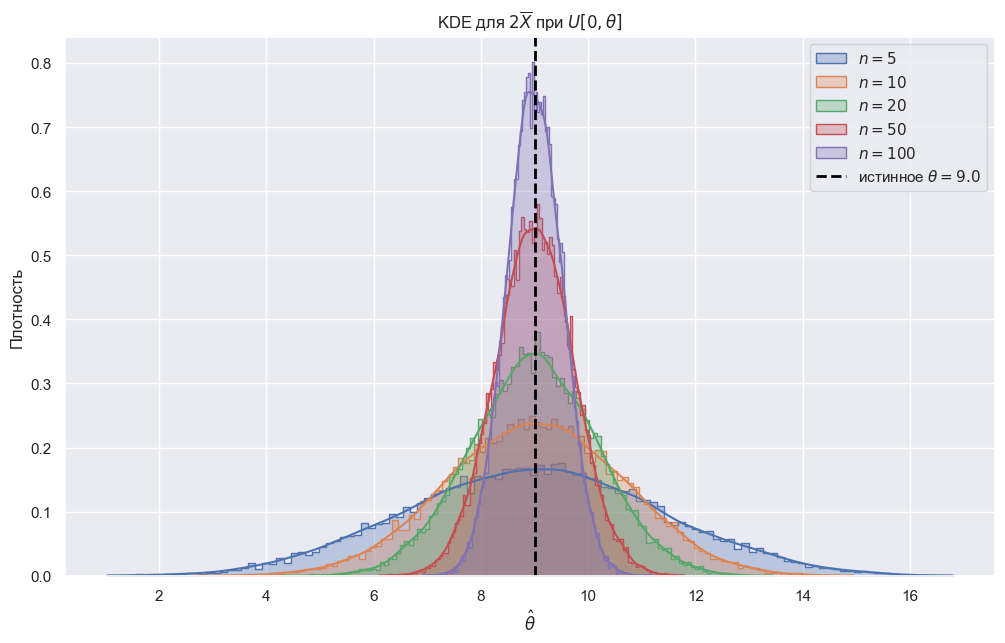

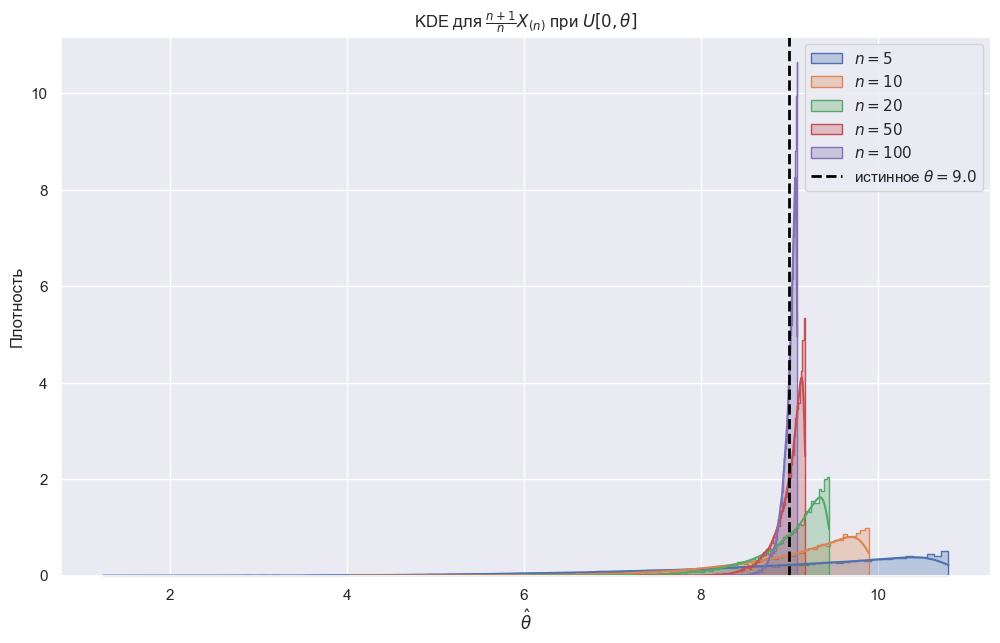

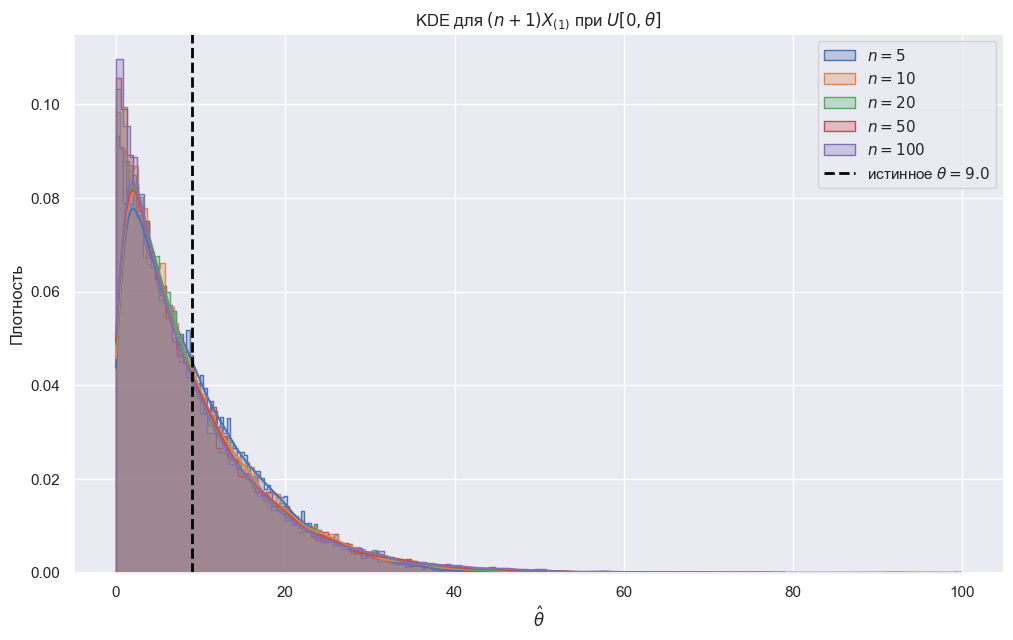

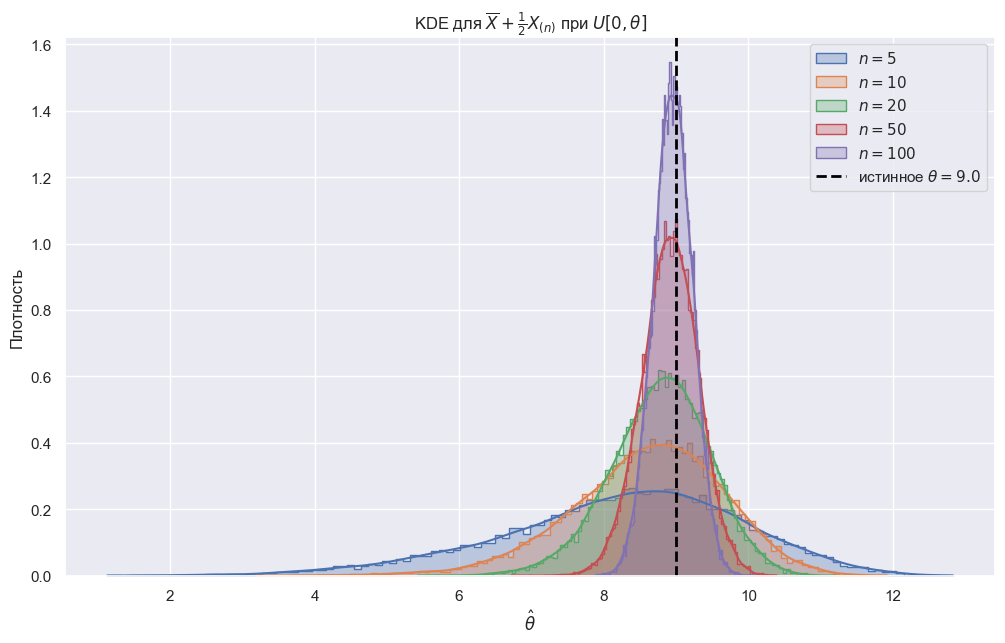

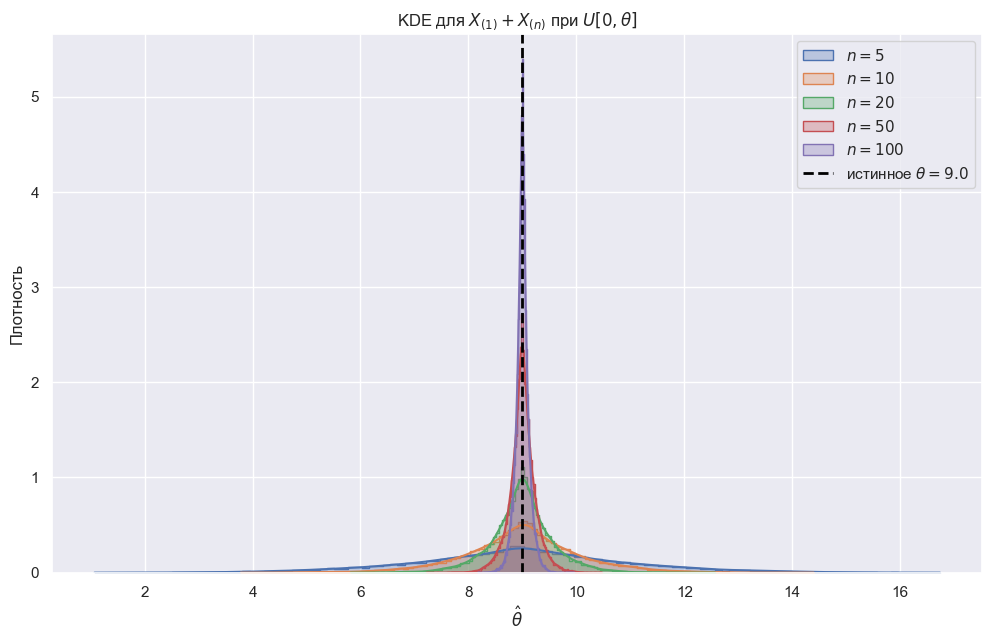

In [449]:
N_LIST = [5, 10, 20, 50, 100]

ESTIMATORS_NAMES = [
    r'$2\overline{X}$',
    r'$\frac{n+1}{n}X_{(n)}$',
    r'$(n+1)X_{(1)}$',
    r'$\overline{X} + \frac{1}{2}X_{(n)}$',
    r'$X_{(1)} + X_{(n)}$'
]

all_estimates = {est: [] for est in ESTIMATORS_NAMES}


def estimators_for_n(n):
    samp = sps.uniform(scale=THETA).rvs(size=(M_REPS, n))
    xbar = samp.mean(axis=1)
    xmin = samp.min(axis=1)
    xmax = samp.max(axis=1)
    return {
        r'$2\overline{X}$': 2.0 * xbar,
        r'$\frac{n+1}{n}X_{(n)}$': ((n + 1) / n) * xmax,
        r'$(n+1)X_{(1)}$': (n + 1) * xmin,
        r'$\overline{X} + \frac{1}{2}X_{(n)}$': xbar + 0.5 * xmax,
        r'$X_{(1)} + X_{(n)}$': xmin + xmax
    }


for n in N_LIST:
    res_n = estimators_for_n(n)
    for est in ESTIMATORS_NAMES:
        all_estimates[est].append((n, res_n[est]))

for est in ESTIMATORS_NAMES:
    _, ax = plt.subplots(figsize=(12, 7))
    for n, arr in all_estimates[est]:
        plot_hist_kde(arr, ax, label=rf'$n={n}$')

    ax.axvline(THETA, color='black', lw=2, ls='--', label=rf'истинное $\theta={THETA}$')
    ax.set_xlabel(r'$\hat{\theta}$')
    ax.set_ylabel('Плотность')
    ax.set_title(rf'KDE для {est} при $U[0,\theta]$')
    ax.legend()
    plt.show()

С ростом $N$ все графики (за исключением $(n+1)X_{(1)}$) сводят свою плотность к $\theta = 9$.

Для $(n+1)X_{(1)}$ плотность с ростом $N$ практически не меняется.

3. Сделайте промежуточный вывод по графикам какая оценка самая лучшая и обоснуйте его. Используйте для этого все полученные результаты.

In [450]:
def frac_close(arr):
    return np.mean(np.abs(arr - THETA) <= EPS)


EPS = 0.25

print(f'Доля внутри |theta_hat - theta| ≤ {EPS}:\n')
for n in N_LIST:
    ests = estimators_for_n(n)
    row = [f'n={n}'] + [f'{frac_close(ests[name]):.3f}' for name in ESTIMATORS_NAMES]
    print(rf"{row[0]}" + "\n" + "\n".join(rf"{nm}: {val}" for nm, val in zip(ESTIMATORS_NAMES, row[1:])))

Доля внутри |theta_hat - theta| ≤ 0.25:

n=5
$2\overline{X}$: 0.085
$\frac{n+1}{n}X_{(n)}$: 0.110
$(n+1)X_{(1)}$: 0.022
$\overline{X} + \frac{1}{2}X_{(n)}$: 0.124
$X_{(1)} + X_{(n)}$: 0.135
n=10
$2\overline{X}$: 0.124
$\frac{n+1}{n}X_{(n)}$: 0.220
$(n+1)X_{(1)}$: 0.019
$\overline{X} + \frac{1}{2}X_{(n)}$: 0.189
$X_{(1)} + X_{(n)}$: 0.246
n=20
$2\overline{X}$: 0.170
$\frac{n+1}{n}X_{(n)}$: 0.437
$(n+1)X_{(1)}$: 0.021
$\overline{X} + \frac{1}{2}X_{(n)}$: 0.288
$X_{(1)} + X_{(n)}$: 0.429
n=50
$2\overline{X}$: 0.264
$\frac{n+1}{n}X_{(n)}$: 0.907
$(n+1)X_{(1)}$: 0.018
$\overline{X} + \frac{1}{2}X_{(n)}$: 0.469
$X_{(1)} + X_{(n)}$: 0.751
n=100
$2\overline{X}$: 0.369
$\frac{n+1}{n}X_{(n)}$: 0.977
$(n+1)X_{(1)}$: 0.022
$\overline{X} + \frac{1}{2}X_{(n)}$: 0.634
$X_{(1)} + X_{(n)}$: 0.935


На графиках KDE для разных N видно, что именно $\frac{n+1}{n}X_{(n)}$ наиболее плотна около $\theta = 9$: у него самые высокие пики и маленькие хвосты. Тонкий момент в том, что на этих графиках с разными $N$ не совсем ясно, что лучше $\frac{n+1}{n}X_{(n)}$ или $X_{(1)} + X_{(n)}$ (т.к. первое скошено, но выше, а второе не скошено, но в 2 раза ниже), но наше утверждение также потверждает теория и код выше:
 - Теория (мы уже считали матожи этих величин в домашке по матстату и доказали несмещенность для всех, кроме $\overline{X} + \frac{1}{2}X_{(n)}$):
 $$
 \mathbb{D}(\frac{n+1}{n}X_{(n)})=[\text{в следующем пункте}]=\frac{\theta^2}{n(n+2)}
 $$
 $$
 \mathbb{D}(X_{(1)}+X_{(n)})=[\text{посчитано ручками через маргинальную плотность, многа техать}]=\frac{2\theta^2}{(n+1)(n+2)}
 $$
 $$
 \frac{2}{(n+1)(n+2)}>\frac{1}{n(n+2)}
 $$
  - В коде тоже видно, что при увеличении N доля $\frac{n+1}{n}X_{(n)}$ начинает обгонять долю $X_{(1)} + X_{(n)}$

4. Для каждой оценки для квадратичной функции потерь найдите эмпирический риск. Для первых трёх оценок посчитайте точный риск. Интеграл можно брать руками, вольфрамом или функцией scipy.integrate.quad. Сделайте выводы о том, хорошо ли эмпирический риск приближает точный риск. После этого сравните оценки на основании эмпирического риска. Совпадает ли порядок с тем, что Вы сделали глядя на графики? Почему?

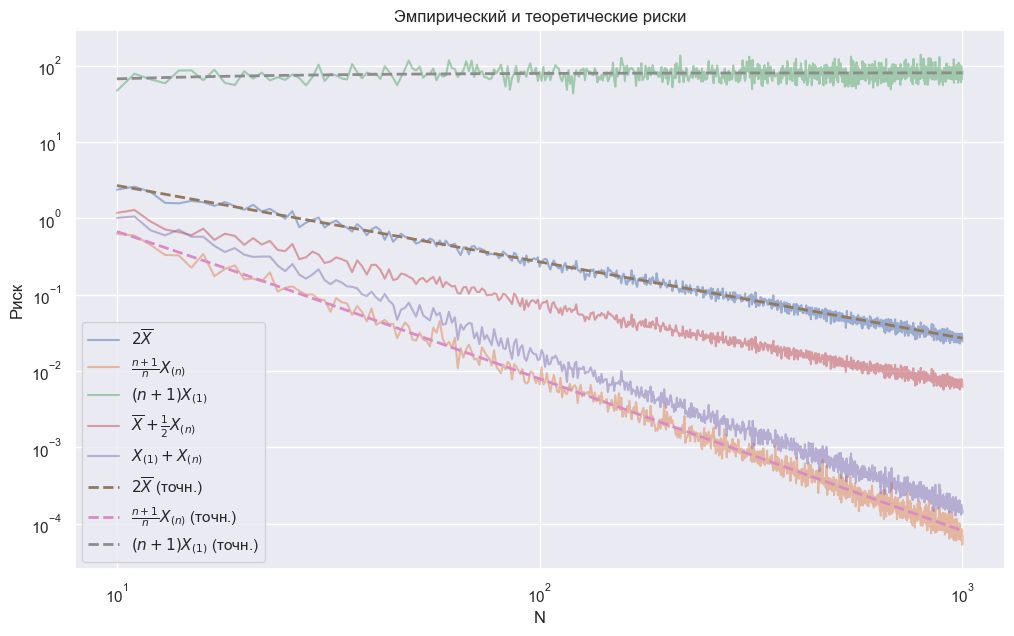

In [451]:
M_REPS = 200
N_LIST = range(10, 1001)


def exact_risk(name, n, theta):
    if name == r'$2\overline{X}$':
        return theta ** 2 / (3 * n)
    if name == r'$\frac{n+1}{n}X_{(n)}$':
        return theta ** 2 / (n * (n + 2))
    if name == r'$(n+1)X_{(1)}$':
        return theta ** 2 * n / (n + 2)
    return np.nan


def mse(arr, theta=THETA):
    return np.mean((arr - theta) ** 2)


results = {name: {'n': [], 'emp': [], 'exact': []} for name in ESTIMATORS_NAMES}

for n in N_LIST:
    ests = estimators_for_n(n)
    for name in ESTIMATORS_NAMES:
        emp = mse(ests[name], THETA)
        ex = exact_risk(name, n, THETA)
        results[name]['n'].append(n)
        results[name]['emp'].append(emp)
        results[name]['exact'].append(ex)

fig, ax = plt.subplots(figsize=(12, 7))
for name in ESTIMATORS_NAMES:
    ax.plot(results[name]['n'], results[name]['emp'], alpha=0.5, label=name)
for name in ESTIMATORS_NAMES[:3]:
    ax.plot(results[name]['n'], results[name]['exact'], linewidth=2, ls='--', label=name + ' (точн.)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('N')
ax.set_ylabel('Риск')
ax.set_title(r'Эмпирический и теоретические риски')
ax.legend()
plt.show()

На семинаре мы доказывали, что все оценки кроме $\overline{X} + \frac{1}{2}X_{(n)}$ несмещенные, а для них риск совпадает с дисперсией: $\href{https://prnt.sc/nohlxzmhuJg1}{\text{Тык}}$.

Видно, что эмпирический риск очень хорошо приближает точный и с ростом $N$ ошибка уменьшается.

Порядок на графике:
$$
R(\frac{n+1}{n}X_{(n)}) < R(X_{(1)} + X_{(n)}) < R(\overline{X} + \frac{1}{2}X_{(n)}) < R(2\overline{X}) < R((n+1)X_{(1)})
$$
Это совпадает с реальным порядком.
Что логично, первые две функции порядка $n^{-2}$, третья и четвертая $n^{-1}$ (правда дисперсию И смещение для $\overline{X} + \frac{1}{2}X_{(n)}$ никто не считал, но на графике отражено именно это), а последняя порядка единицы, так как горизонтальна.

Вычисления в прошлом пункте (косвенно, ибо там плотности - об этом в следующей клетке) подтверждают то же самое.

Какой характеристикой распределения является квадратичный риск? Какому свойству графика плотности оценки она соответствует?

**Ответ**:
$$
R(\theta^*,\theta)=\mathbb {E}_\theta((\theta^*-\theta)^2)
=\mathbb {D}_\theta(\theta^*)+(\mathbb {E}_\theta\theta^*-\theta)^2.
$$
В среднеквадратичном подходе риск представляет из себя сумму дисперсии и квадрата смещения. На графике плотности это будет соответствовать свойствам:
  - Риск меньше: Высокий и/или узкий пик смещающийся к $\theta$ с ростом размера выборки и маленькими хвостами
  - Риск больше: Удалённость пика ОТ $\theta$ с ростом размера выборки и большими хвостами

5. Предложите 2 другие осмысленные функции потерь (какие свойства должны быть у функции, чтобы быть осмысленной?) и посчитайте эмпирические риски. Будут ли оценки сравниваться также или нет?

Выберем 2 существующие функции потерь, которые используются на практике ($\href{https://www.comet.com/site/blog/5-regression-loss-functions-all-machine-learners-should-know/}{\text{source}}$): Функцию средне абсолютной ошибки (MAE) и лог-шинус (log-cosh).

Для "осмысленности", нам нужны: дифференцируемы (например, чтобы использовать градиентный спуск и найти оптимальную оценку параметра); выпуклось (т.е. наличие минимума); устойчивость к выбросам (чтобы работать с зашумленными данными); и, наверное, чтобы это не был какой-то большой и страшный интеграл, чтобы была хорошая скорость вычисления.

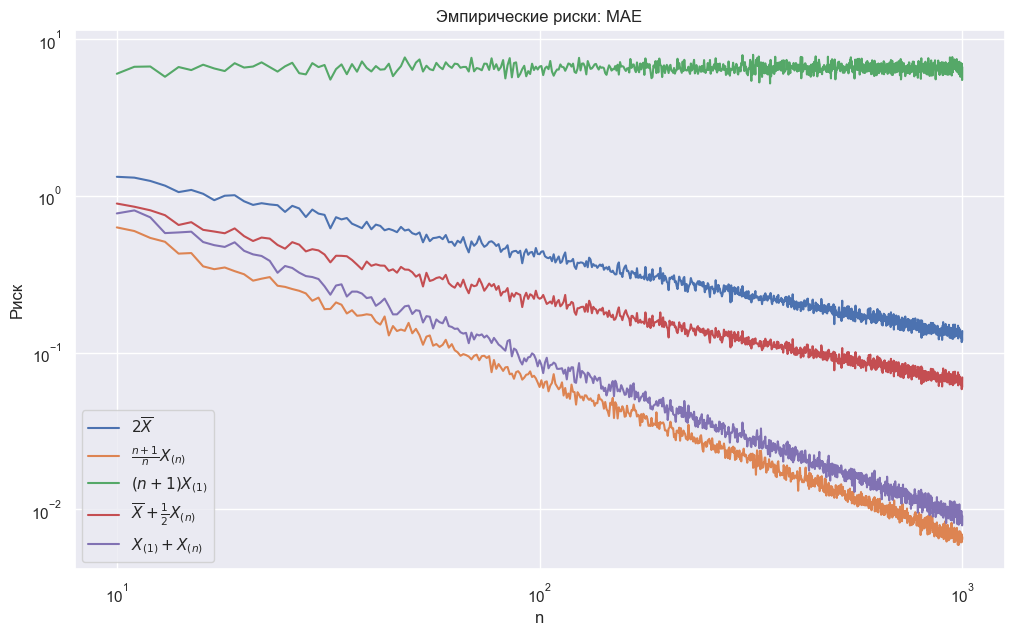

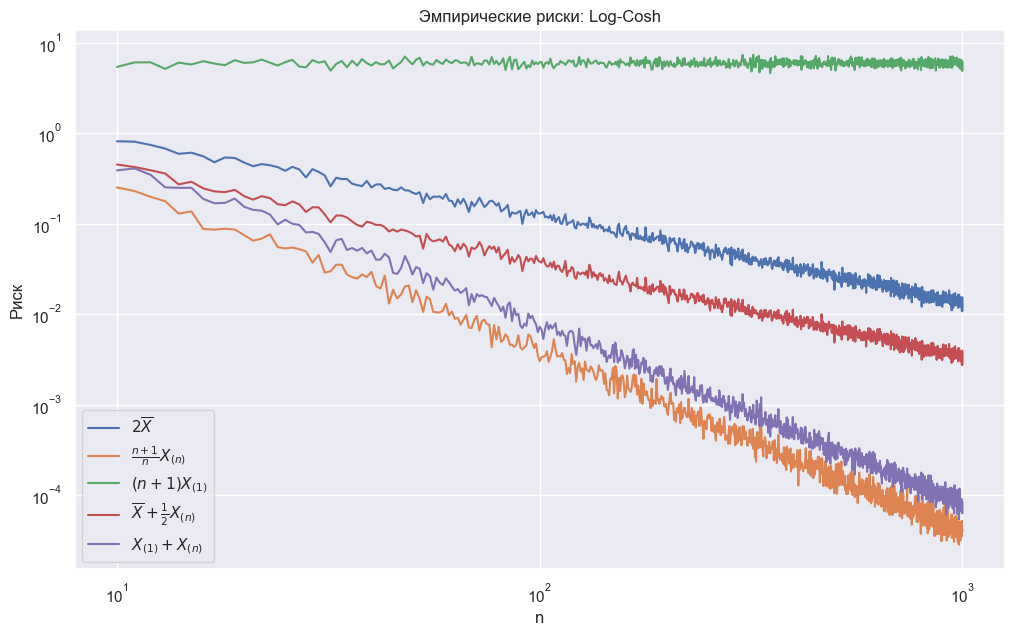

In [452]:
def loss_mae(e):
    return np.abs(e)


def loss_logcosh(e):
    return np.log(np.cosh(e))


def empirical_risk(arr, loss):
    return np.mean(loss(arr - THETA))


LOSS_FUNCS = {
    'MAE': loss_mae,
    'Log-Cosh': loss_logcosh,
}
RISKS = {lf_name: {name: [] for name in ESTIMATORS_NAMES} for lf_name in LOSS_FUNCS}

for n in N_LIST:
    ests = estimators_for_n(n)  # должен возвращать dict {имя оценки -> массив длины M_REPS}
    for lf_name, lf in LOSS_FUNCS.items():
        for name in ESTIMATORS_NAMES:
            RISKS[lf_name][name].append(empirical_risk(ests[name], lf))

for lf_name in LOSS_FUNCS:
    fig, ax = plt.subplots(figsize=(12, 7))
    for name in ESTIMATORS_NAMES:
        ax.plot(N_LIST, RISKS[lf_name][name], label=name)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('n')
    ax.set_ylabel('Риск')
    ax.set_title(f'Эмпирические риски: {lf_name}')
    ax.legend()
    plt.show()

На графиках видно, что порядок остался тем же, разве что log-cosh убывает быстрее, чем MAE, и больше похож на MSE.

6. До текущего момента мы сравнивали риск для конкретного значения параметра. Если для каждого значения параметра риск одной оценки оказывается лучше, чем другой, то первая оценка считается лучше в равномерном подходе. Хоть у нас именно этот случай и реализовался, это редкий случай. Часто оказывается, что для одних значений параметров одни оценки лучше других, а для других значений наоборот. В этом случае используют байесовский подход.

Предложите некоторую плотность распределений самого параметра, просемплируйте из неё 10-100 значений и посчитайте байесовский эмпирический риск. Байесовский риск это интеграл (в нашем случае среднее) риска при случайном значении параметра. Объясните, из каких прикладных соображений следует выбирать плотность распределения параметра?

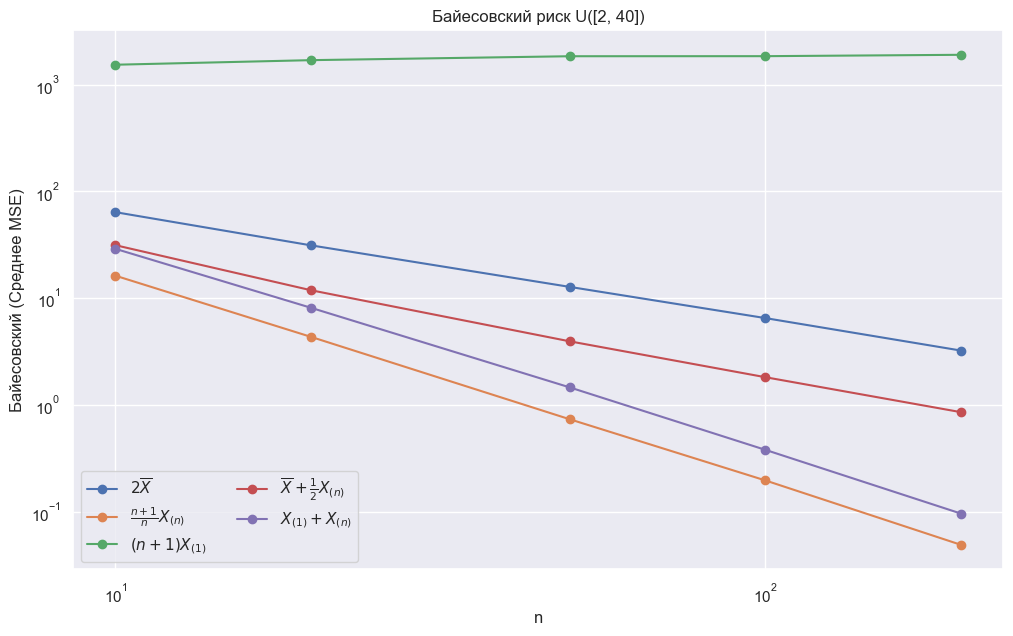

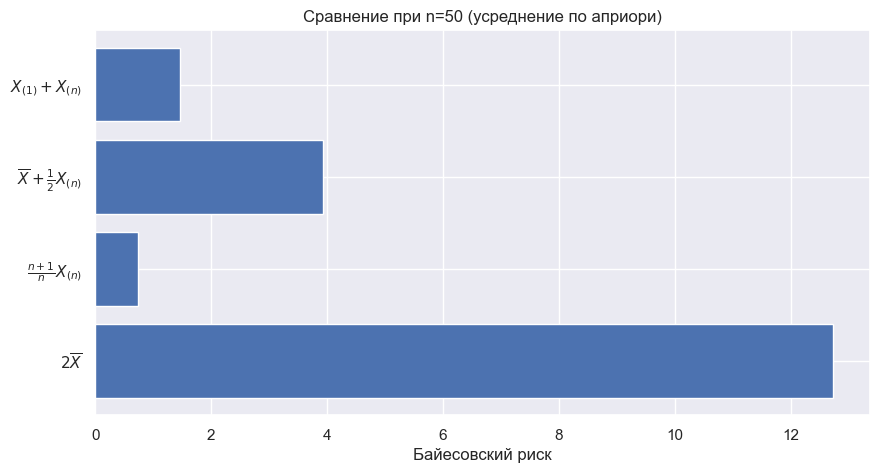

In [453]:
def estimators_for_n_theta(n, theta):
    samp = sps.uniform(scale=theta).rvs(size=(M_REPS, n))
    xbar = samp.mean(axis=1)
    xmin = samp.min(axis=1)
    xmax = samp.max(axis=1)
    return {
        r'$2\overline{X}$': 2.0 * xbar,
        r'$\frac{n+1}{n}X_{(n)}$': ((n + 1) / n) * xmax,
        r'$(n+1)X_{(1)}$': (n + 1) * xmin,
        r'$\overline{X} + \frac{1}{2}X_{(n)}$': xbar + 0.5 * xmax,
        r'$X_{(1)} + X_{(n)}$': xmin + xmax,
    }


N_LIST = [10, 20, 50, 100, 200]
M_REPS = 5000
K_THETA = 100
THETA_LOW, THETA_HIGH = 2.0, 40.0
thetas = sps.lognorm(s=2.0, scale=1.0).rvs(size=K_THETA)

bayes_risk = {name: [] for name in ESTIMATORS_NAMES}

for n in N_LIST:
    risks_n = {name: [] for name in ESTIMATORS_NAMES}
    for theta_j in thetas:
        ests = estimators_for_n_theta(n, theta_j)
        for name in ESTIMATORS_NAMES:
            risks_n[name].append(mse(ests[name], theta_j))
    for name in ESTIMATORS_NAMES:
        bayes_risk[name].append(np.mean(risks_n[name]))

fig, ax = plt.subplots(figsize=(12, 7))
for name in ESTIMATORS_NAMES:
    ax.plot(N_LIST, bayes_risk[name], marker='o', label=name)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('Байесовский (Среднее MSE)')
ax.set_title('Байесовский риск U([2, 40])')
ax.legend(ncol=2)
plt.show()

n0 = 50
i0 = int(np.searchsorted(N_LIST, n0))
names = ESTIMATORS_NAMES[:2] + ESTIMATORS_NAMES[3:]  # в (n+1)X_(1) - сильно другой масштаб
vals = [bayes_risk[name][i0] for name in names]

plt.figure(figsize=(10, 5))
plt.barh(names, vals)
plt.xlabel('Байесовский риск')
plt.title(f'Сравнение при n={n0} (усреднение по априори)')
plt.show()

Итак, прикладное соображение: Так как Байесовский риск - это средняя ошибка по $\theta_j$-м, то разумно брать такое распределение, которое будет концентрировать плотность так, как распределены наши $\theta$ в задаче.

Как пример: допустим кафедра ДМ видит (допустим провели опрос), что студенты выполняют один пункт задания в праке по матстату 42 часа +- 2 часа, то имеет смысл за априорное распределения взять такое, у которого масса концентрируется около $\theta = 42$ с маленькими хвостами (скорее всего какое-нибудь гамма или нормальное). Или наоборот, если показания расходятся в разы, допустим, 3 часа, 10 часов, 150 часов (т.е. масштаб непонятен), то имеет смысл взять какие-нибудь из лог-распределений ($\href{https://ru.wikipedia.org/wiki/Логнормальное_распределение}{например}$), т.к. мы допускаем, что все $\theta$ распределены +- одинаково (мы не знаем масштаб, опять же). Или вот ещё: если по опросу студенты не могут решать пункт меньше чем за 2 часа, но точно не больше 50 часов (дедлайн), то можно взять равномерное на $[2, 50]$.

Сделайте выводы о том, какая оценка оказалась лучше. В выводе отметьте, с какой скоростью сходились точные риски первых трёх оценок и как это влияет на точность оценки.

**Вывод:**

Вывод повторяет рассуждения из других пунктов:

$\frac{n+1}{n}X_{(n)}$ - лучшая.

Скорости точных рисков: $R(\frac{n+1}{n}X_{(n)})=O(n^{-2}), R(2\overline{X})=O(n^{-1}), R((n+1)X_{(1)})=O(1)$.

С большей скоростью сходимости функции рисков - ошибка меньше. В случае с $R((n+1)X_{(1)})=const$, точность не растёт вообще, оценка несостоятельна. То есть, чем быстрее убывает $R$, тем меньше вероятность взорвать реактор.

### Задача 4

В этой задаче мы проверим теорему Гливенко-Кантелли, как результат, гарантирующий что эмпирически посчитанные величины хорошо приближают теоретические.

В этой задаче Вам предстоит:
- Построить эмпирическую функцию распределения для разных размеров выборки и сравнить её с теоретической функцией.
- Построить одну из ключевых статистик: статистику Колмогорова и изучить её предельные свойства

1. Для стандартного нормального распределения сгенерируйте 10000 выборок размера 10000. Для каждой выборки посчитайте эмпирическую функцию распределения для некоторой сетки. Напомним, что эмпирическая функция распределения (ЭФР) это $\hat{F}(x) = \frac{1}{n}\sum\limits_{i=1}^n I(x \leq X_i)$, где $X_i$ это элемент выборки.

In [454]:
def edf_n(n, samples):
    edf_all = []
    for i in range(M_REPS):
        edf = np.searchsorted(samples[i], x_grid, side='right') / n  # sum(I{X_k <= x}) / n
        edf_all.append(edf)
    return np.array(edf_all)


M_REPS = 10000
N = 10000
x_grid = np.linspace(-4, 4, 1001)

samples = sps.norm.rvs(size=(M_REPS, N))
samples.sort(axis=1)

edf_all = edf_n(N, samples)

Для некоторых размеров выборки (лучше не больше 6 разных) постройте на графике ЭФР и теоретическую функцию распределения. Как ведёт себя ЭФР с ростом параметра?

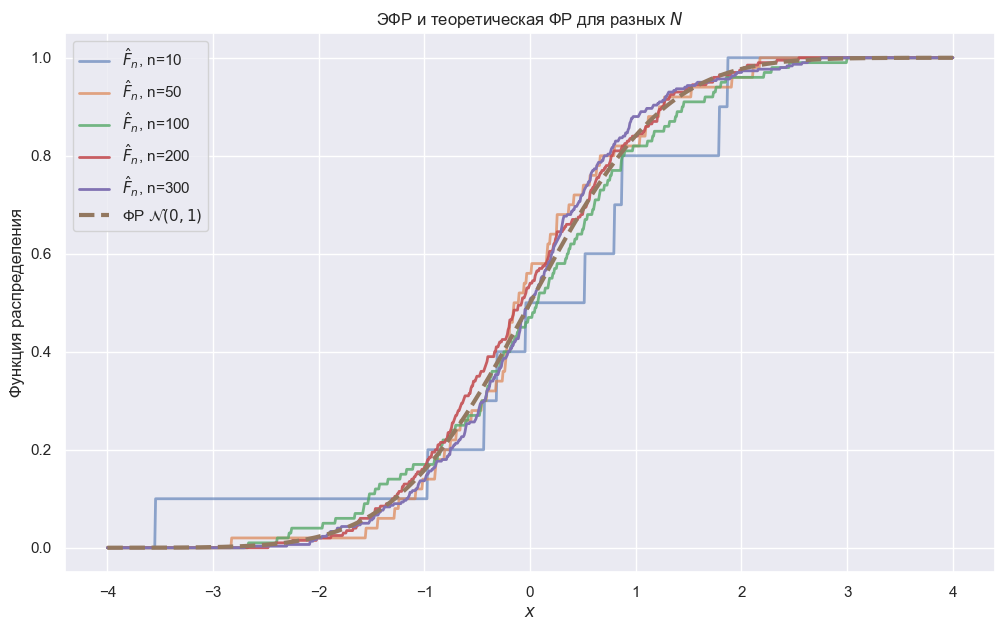

In [455]:
N_LIST = [10, 50, 100, 200, 300]


def edf_curve(sample, grid):
    sample_sorted = np.sort(sample)
    return np.searchsorted(sample_sorted, grid, side='right') / sample_sorted.size


alpha = 0.6
plt.figure(figsize=(12, 7))
for n in N_LIST:
    sample = sps.norm.rvs(size=n)
    F_hat = edf_curve(sample, x_grid)
    plt.plot(x_grid, F_hat, lw=2, alpha=alpha, label=fr'$\hat F_n$, n={n}')
    if alpha + 0.1 <= 1:
        alpha += 0.1

plt.plot(x_grid, sps.norm.cdf(x_grid), '--', lw=3, label=r'ФР $\mathcal{N}(0,1)$')
plt.xlabel(r'$x$')
plt.ylabel('Функция распределения')
plt.title('ЭФР и теоретическая ФР для разных $N$')
plt.legend()
plt.show()

На графике видно, что по мере роста $N$ эмпирическая ФР приближается к теоретической.

2. Теорема Гливенко-Кантелли утверждает, что $D_n = \sup\limits_{x \in \mathbb{R}}|\hat{F}(x) - F(x)|$ стремится к нулю почти наверное. Посчитайте, чему равен этот супремум численно и как он себя ведёт с ростом $n$. Проверили ли мы теорему?

In [456]:
F_grid = sps.norm.cdf(x_grid)

N_LIST = [20, 50, 100, 500, 2000, 10000]
M_REPS = 1000

Dn_by_n = {}
for n in N_LIST:
    samples = sps.norm.rvs(size=(M_REPS, n))
    samples.sort(axis=1)
    Dn_by_n[n] = np.max(np.abs(edf_n(n, samples) - F_grid[None, :]), axis=1)

for n in N_LIST:
    print(f"n={n:6d}\t"
          f"mean={Dn_by_n[n].mean():.4f}\t"
          f"median={np.median(Dn_by_n[n]):.4f}\t")

n=    20	mean=0.1859	median=0.1774	
n=    50	mean=0.1188	median=0.1116	
n=   100	mean=0.0832	median=0.0784	
n=   500	mean=0.0380	median=0.0364	
n=  2000	mean=0.0186	median=0.0177	
n= 10000	mean=0.0084	median=0.0080	


Во вычислениям видно, что $D_n$ стабильно убывает по мере роста $n$.

Мы взяли среднее и медиану, чтобы это проследить, ибо с одним повторением, бывает, что при одной выборке размера $n$ число $D_n$ больше предыдущего (в силу рандомности выборки).

3. Промоделируйте статистику $\sqrt{n}D_n$ для n = 10000 и постройте её KDE. Затем промоделируйте эту же статистику не для нормального распределения, а для 3 других любых предложенных Вами распределений. Если вычисления застрянут, можете уменьшить число выборок или размер выборки. Будет ли итоговая плотность такой же?

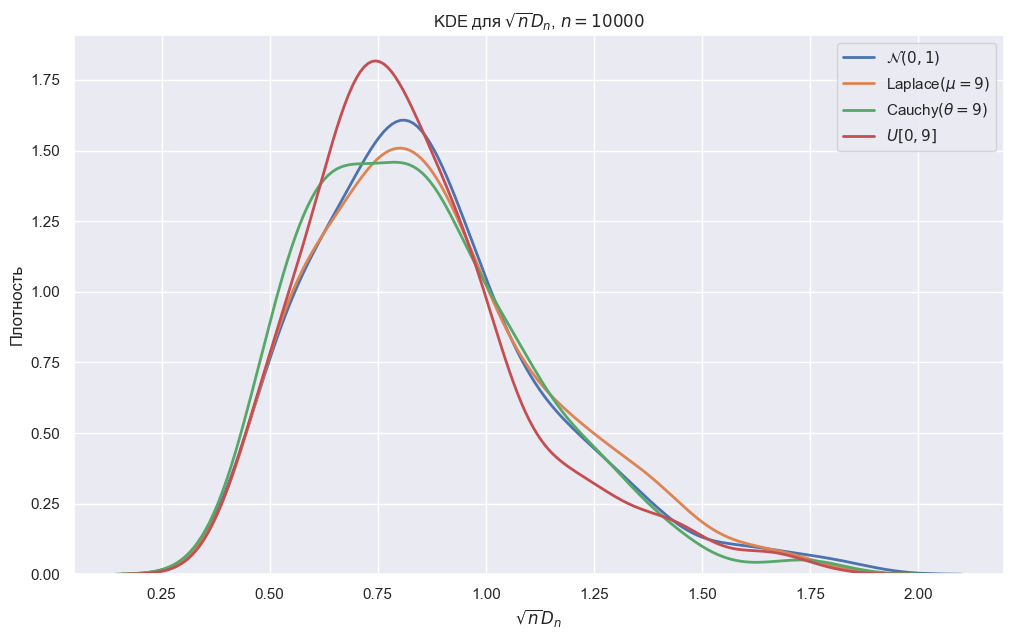

In [457]:
import numpy as np
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

M_REPS = 300
GRID_SIZE = 2001
EPS = 1e-3

uni_grid = np.linspace(EPS, 1 - EPS, GRID_SIZE)


def sqrtn_Dn_prob_grid(dist, n, m, u):
    x_grid = dist.ppf(u)
    out = np.empty(m)
    samples = dist.rvs(size=(m, n))
    samples.sort(axis=1)
    for i in range(m):
        ecdf = np.searchsorted(samples[i], x_grid, side='right') / n
        out[i] = np.sqrt(n) * np.max(np.abs(ecdf - u))
    return out


distrs = {
    r'$\mathcal{N}(0,1)$': sps.norm,
    r'Laplace$(\mu=9)$': sps.laplace(loc=9, scale=1),
    r'Cauchy$(\theta=9)$': sps.cauchy(loc=9, scale=1),
    r'$U[0,9]$': sps.uniform(loc=0, scale=9),
}

results = {name: sqrtn_Dn_prob_grid(dist, N, M_REPS, uni_grid) for name, dist in distrs.items()}

plt.figure(figsize=(12, 7))
for name, arr in results.items():
    sns.kdeplot(arr, lw=2, fill=False, label=name)
plt.xlabel(r'$\sqrt{n} D_n$')
plt.ylabel('Плотность')
plt.title(r'KDE для $\sqrt{n}D_n$, $n=10000$')
plt.legend()
plt.show()

KDE у всех 4-х графиков практически совпадает.

Судя по количеству повторений, распределение по крайней мере не нормальное.

4. На просторах интернета, в беседе с умными людьми или на скале в пещере найдите, к чему сходится по распределению статистика $\sqrt{n}D_n$? Какое есть применение у этого крупного результата?

**Ответ:**

На просторах интернета, во время разговора с умными людьми в пещере, которая находится на скале и при луне, я узнал, что ([$\href{https://prnt.sc/lGycgXutKbQt}{тык}$][$\href{https://prnt.sc/zP8z6y4QEuWV}{тык}$][$\href{https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test}{тык}$]) если $F_0$ - непрерывная ФР при гипотезе $H_0: F=F_0$, а
$D_n=\sup_x |F_n^*(x)-F_0(x)|$, то статистика $\sqrt{n} D_n$ сходится п.н. к $K(t)$:
$$
\lim_{n\to\infty}\mathbb P(\sqrt{n} D_n \le t)=K(t), (\text{Теорема Колмогорова})
$$
где $K(t)$ - функция распределения Колмогорова:
$$
K(t)=\sum_{j=-\infty}^{\infty}(-1)^j e^{-2j^2 t^2}=1-2\sum_{k=1}^{\infty}(-1)^{k-1}e^{-2k^2 t^2}
$$

Чем это классно? В тыке есть так называемая *Теорема Колмогорова*, и следующий за ней, *Критерий Колмогорова*, последний выпишу:
$$
\text{гипотеза }H_0\text{ не верна} \Longleftrightarrow\ \sqrt{n}D_n > K_{1-\alpha},
$$
где $K_{1-\alpha}$ это $(1-\alpha)$-квантиль функции $K(t)$.

Иначе, можно записать:
$$
\mathbb P(\sup_x |F_n^*(x)-F_0(x)|) \le \frac{K_{1-\alpha}}{\sqrt{n}})\approx 1-\alpha
$$

И если немного (много) подумать, то это очень крутой результат, так как теперь, мы можем проверять, насколько полученные данные похожи на то или иное распределение (а ведь весь предмет про это (?)). Сейчас приведу пример, но для начала про $\alpha$: по сути это параметр вероятности false-positive-ов: чем меньше $\alpha$, тем реже мы будем говорить, что гипотеза $H_0$ неверна, когда она на самом деле верна.

Но почему бы не взять $\alpha$ каким-нибудь очень маленьким? Тогда требования к размеру выборки будет очень сильно расти, что логично - из критерия получается, что (помним про Гвиленко-Кантелли):
$$
n > (\frac{K_{1-\alpha}}{D_n})^2
$$

Обещанный пример (кратенько):

Гипотеза $H_0: F \sim \mathcal{N}(0,1)$.

Считаем $D_n$ между ЭФР $F$ и $\mathcal{N}(0,1)$. Пусть , $\alpha=0.05$ и получили $D_n=0.09$.
$$
\alpha \approx 2e^{-2t^2}  t \approx \sqrt{\frac{1}{2} \ln \frac{2}{\alpha}}
= \sqrt{\frac{1}{2} \ln \frac{2}{0.05}} \approx 1.36
$$
Критерий при $n=100$: $\sqrt{100} \cdot 0.09 = 0.9 < 1.36 \Rightarrow$ говорим, что гипотеза $H_0$ верна.

Если бы $n=400$ и тот же $D_n=0.09$: $\sqrt{400} \cdot 0.09 = 0.18 > 1.36 \Rightarrow$ говорим, что гипотеза $H_0$ неверна.

Значит по критерию, скорее всего, наши данные имеют не нормально распределение, а какое-то другое.

Вообще, этот критерий лучше подходит, чтобы опровергать $H_0$, ибо если гипотеза ложна, то с ростом размера выборки, тест почти наверняка будет давать правильный результат. А если гипотеза верна, то вероятность false-positive будет +- такая же.

Зря я так, наверное, но ладно, хотя бы интересно было :)

~~Жалко, что 5-е задание теперь не успею~~

~~Ещё больше жалко будет, если я тут где-то накосячил, но если вы прочитали это полотно - всё равно спасибо~~
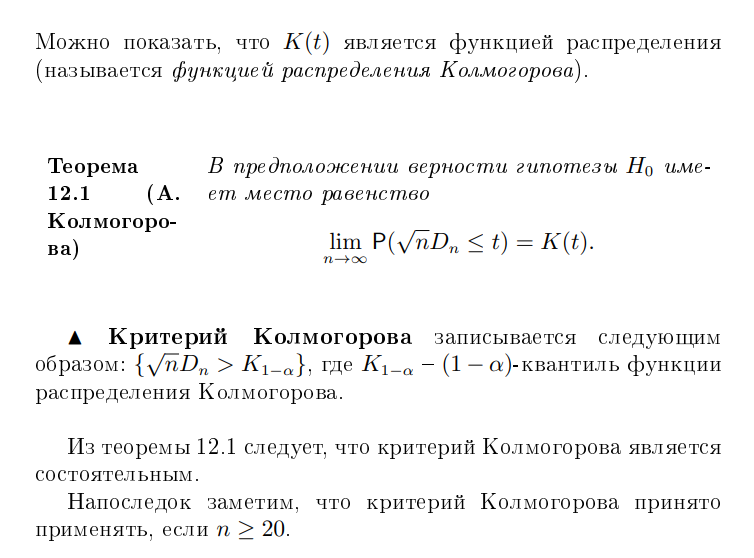

5. Если Вы нашли ответ на вопрос выше, проверьте что Ваше распределение совпадает с теоретическим пределом при помощи QQ-plot

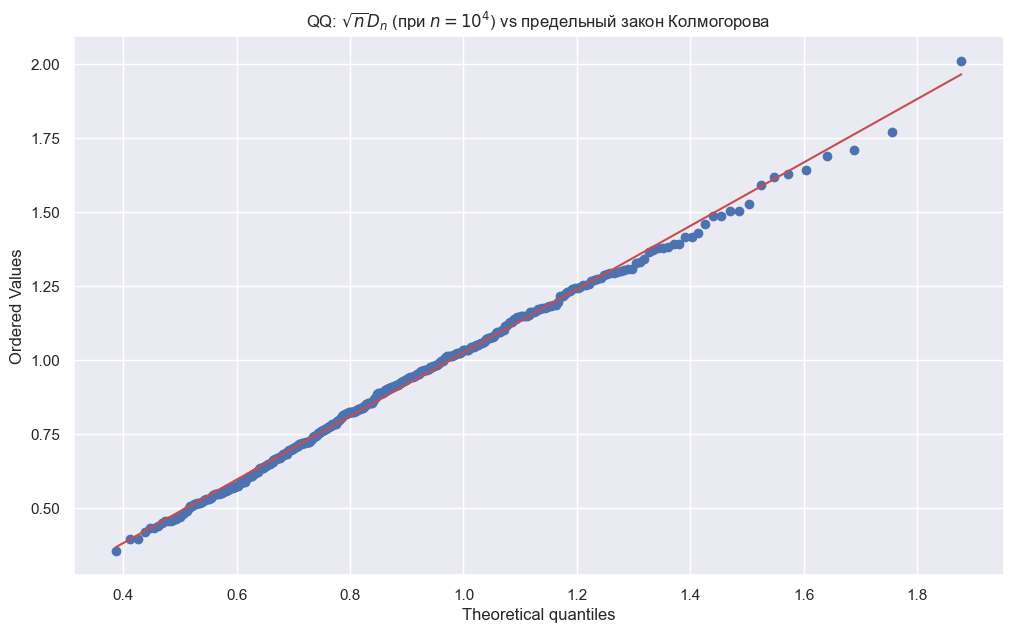

In [458]:
N = 10000
M_REPS = 400

x_grid = np.linspace(-4, 4, GRID_SIZE)
Phi_grid = sps.norm.cdf(x_grid)

vals = np.empty(M_REPS)
samples = sps.norm.rvs(size=(M_REPS, N))
samples.sort(axis=1)
for i in range(M_REPS):
    ecdf = np.searchsorted(samples[i], x_grid, side='right') / N
    vals[i] = np.sqrt(N) * np.max(np.abs(ecdf - Phi_grid))

plt.figure(figsize=(12, 7))
sps.probplot(vals, dist=sps.kstwobign, plot=plt)
plt.title(r'QQ: $\sqrt{n}D_n$ (при $n=10^4$) vs предельный закон Колмогорова')
plt.show()

Судя по графику совпадает - радуемся.

### Задача 5

В этой задаче мы проверим предельные свойства оценок и познакомимся с таким понятием как гипернормальная сходимость.

В этой задаче Вам предстоит:
- Изучить предельные распределения и скорости сходимости разных оценок
- Понять как теоретические результаты могут предложить гарантию качества на практике

1. Сгенерируйте $N=400$ выборок из равномерного распределения $\mathrm U{[0, \theta]}$ для $\theta=9$ размера $n=40$. Посчитайте оценки $\hat\theta = 2\overline{X}, \ \theta^* = \frac{n+1}{n} X_{(n)}$ и нарисуйте их KDE на одном графике.

Мы этим уже занимались (см. зад.3 п.1).

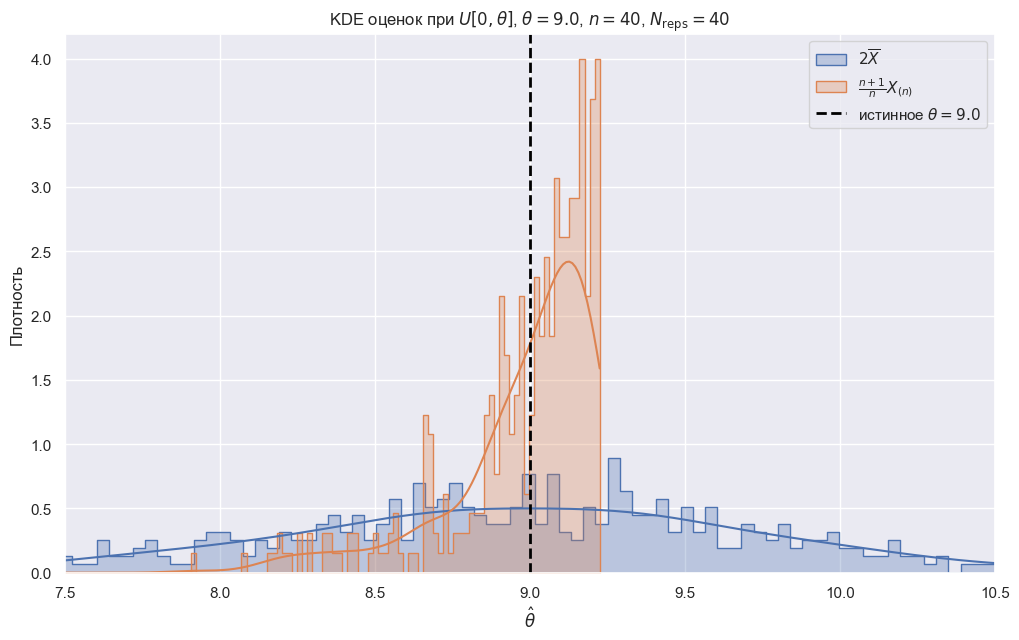

In [459]:
THETA = 9.0
n = 40
N = 400

samples = sps.uniform(scale=THETA).rvs(size=(N, n))

xbar = samples.mean(axis=1)
xmax = samples.max(axis=1)

theta_hat = {
    r'$2\overline{X}$': 2.0 * xbar,
    r'$\frac{n+1}{n}X_{(n)}$': ((n + 1) / n) * xmax,
}

_, ax = plt.subplots(figsize=(12, 7))
for k in theta_hat:
    plot_hist_kde(theta_hat[k], ax, label=k)
ax.axvline(THETA, color='black', lw=2, ls='--', label=rf'истинное $\theta={THETA}$')
ax.set_xlim(THETA - 1.5, THETA + 1.5)
ax.set_title(rf'KDE оценок при $U[0,\theta]$, $\theta={THETA}$, $n={n}$, $N_\mathrm{{reps}}={n}$')
ax.set_xlabel(r'$\hat{\theta}$')
ax.set_ylabel('Плотность')
ax.legend()
plt.show()

2. Численно и визуально проверьте, что обе оценки сходятся по вероятности к своему параметру.

Мы этим уже занимались (см. зад.3 п.2), по крайней мере визуальной частью.

In [460]:
THETA = 9.0
N = 10000
N_LIST = [5, 10, 20, 50, 100]
EPS = [0.05 * THETA, 0.02 * THETA]

print("  n |  P(|2X-theta|>0.05)  P(|2X-theta|>0.02) ||   P(|theta*-theta|>0.05)  P(|theta*-theta|>0.02)")
for n in N_LIST:
    samp = sps.uniform(scale=THETA).rvs(size=(N, n))
    th_mean = 2.0 * samp.mean(axis=1)
    th_star = ((n + 1) / n) * samp.max(axis=1)
    p1 = np.mean(np.abs(th_mean - THETA) > EPS[0])
    p2 = np.mean(np.abs(th_mean - THETA) > EPS[1])
    q1 = np.mean(np.abs(th_star - THETA) > EPS[0])
    q2 = np.mean(np.abs(th_star - THETA) > EPS[1])
    print(f"{n:3d} |   {p1:10.3f}           {p2:10.3f}       ||      {q1:10.3f}            {q2:10.3f}")

  n |  P(|2X-theta|>0.05)  P(|2X-theta|>0.02) ||   P(|theta*-theta|>0.05)  P(|theta*-theta|>0.02)
  5 |        0.847                0.940       ||           0.801                 0.919
 10 |        0.781                0.913       ||           0.603                 0.851
 20 |        0.705                0.875       ||           0.137                 0.696
 50 |        0.544                0.809       ||           0.030                 0.137
100 |        0.383                0.731       ||           0.002                 0.049


Обе оценки убывают с ростом $n \Rightarrow$ сходятся по вероятности к $\theta$

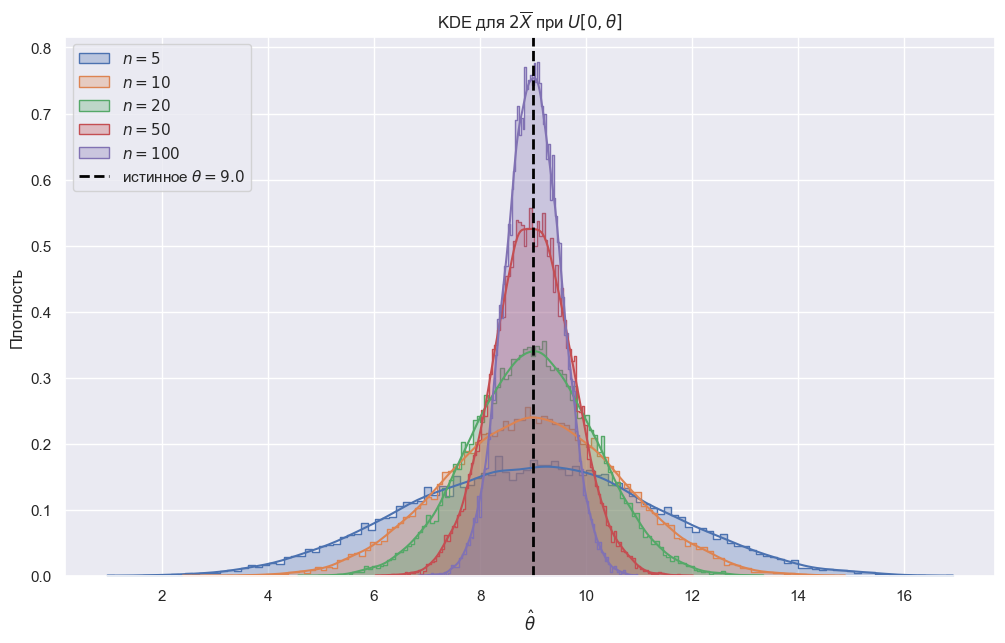

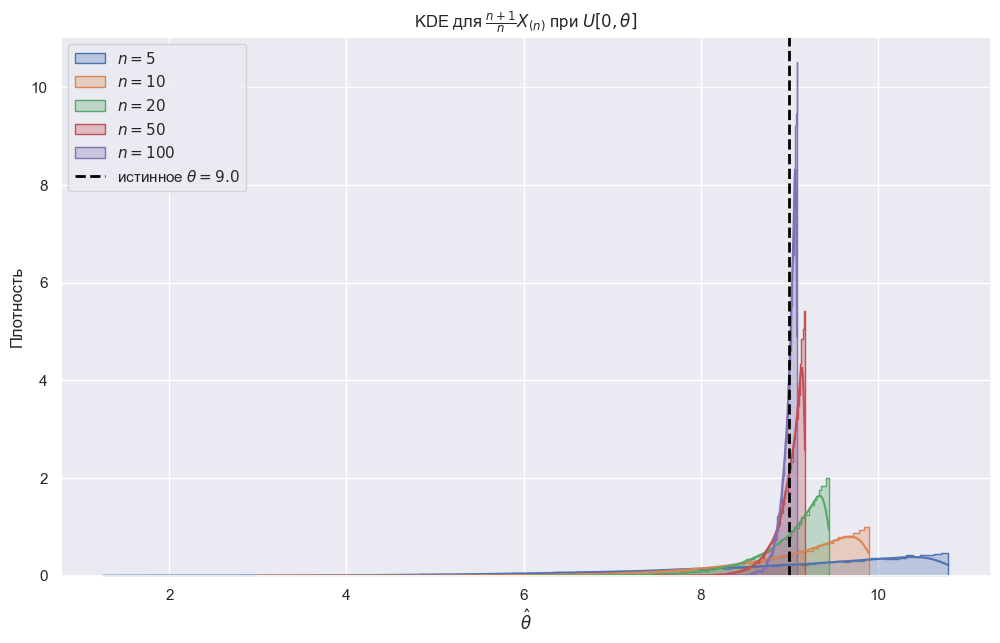

In [461]:
def estimators_for_n_cut(n):
    samp = sps.uniform(scale=THETA).rvs(size=(N, n))
    xbar = samp.mean(axis=1)
    xmax = samp.max(axis=1)
    return {
        r'$2\overline{X}$': 2.0 * xbar,
        r'$\frac{n+1}{n}X_{(n)}$': ((n + 1) / n) * xmax,
    }


N = 20000

all_estimates = {est: [] for est in [r'$2\overline{X}$', r'$\frac{n+1}{n}X_{(n)}$']}
for n in N_LIST:
    res_n = estimators_for_n_cut(n)
    for est in all_estimates:
        all_estimates[est].append((n, res_n[est]))

for est in all_estimates:
    _, ax = plt.subplots(figsize=(12, 7))
    for n, arr in all_estimates[est]:
        plot_hist_kde(arr, ax, label=rf'$n={n}$')
    ax.axvline(THETA, color='black', lw=2, ls='--', label=rf'истинное $\theta={THETA}$')
    ax.set_xlabel(r'$\hat{\theta}$')
    ax.set_ylabel('Плотность')
    ax.set_title(rf'KDE для {est} при $U[0,\theta]$')
    ax.legend(loc='upper left')
    plt.show()

*Рассуждения аналогичны рассуждениям в 3-ем задании*.

3. Промоделируйте статистики $\sqrt{n} (\hat\theta - \theta)$ и $\theta - n  (\theta^* - \theta)$. К чему сходятся их распределения с ростом $n$?

(было $1 - n  (\theta^* - \theta)$ - в чате сказали, что это косяк)

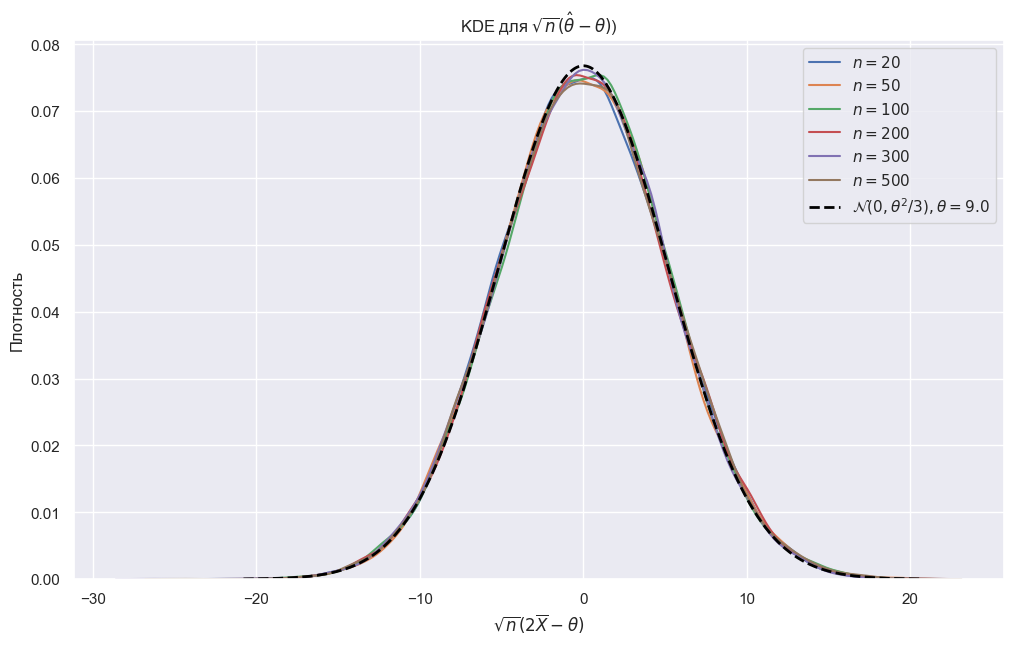

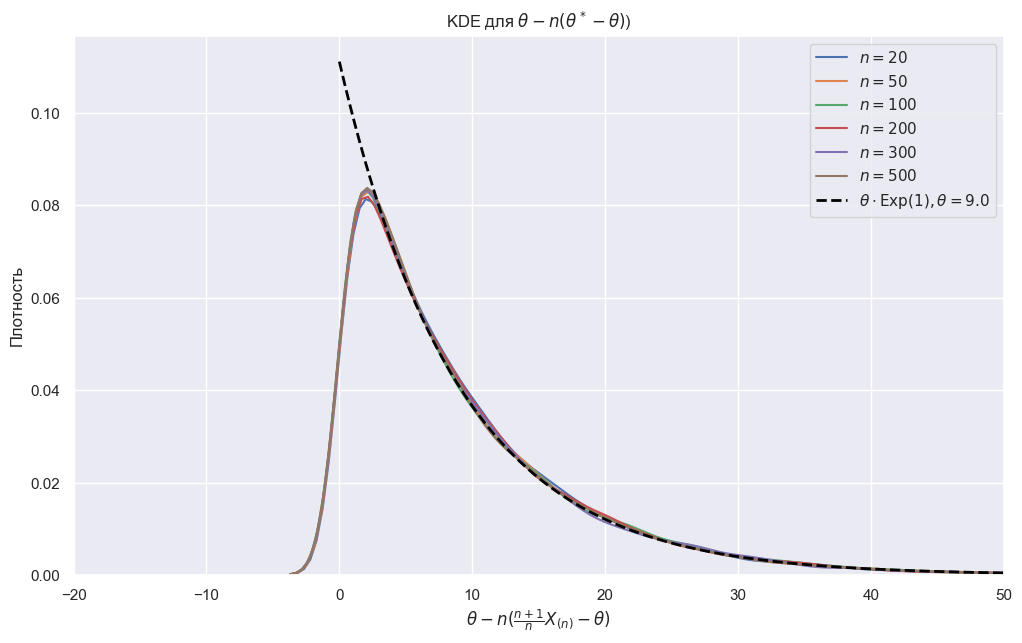

In [462]:
THETA = 9.0
N = 20000
N_LIST = [20, 50, 100, 200, 300, 500]


def stats_for_n(n, m):
    samp = sps.uniform(scale=THETA).rvs(size=(m, n))
    z1 = np.sqrt(n) * (2.0 * samp.mean(axis=1) - THETA)
    xmax = samp.max(axis=1)
    theta_star = ((n + 1) / n) * xmax
    z2 = THETA - n * (theta_star - THETA)
    return z1, z2


x1 = np.linspace(-4 * THETA / np.sqrt(3), 4 * THETA / np.sqrt(3), 1200)
norm_pdf = sps.norm(loc=0, scale=THETA / np.sqrt(3)).pdf(x1)

x2 = np.linspace(0, 8 * THETA, 1500)
exp_pdf = (1 / THETA) * np.exp(-x2 / THETA)

plt.figure(figsize=(12, 7))
for n in N_LIST:
    z1, _ = stats_for_n(n, N)
    sns.kdeplot(z1, lw=1.5, label=rf'$n={n}$')
plt.plot(x1, norm_pdf, '--', color='black', lw=2, label=rf'$\mathcal{{N}}(0,\theta^2/3), \theta={THETA}$')
plt.title(r'KDE для $\sqrt{n}(\hat\theta-\theta)$)')
plt.xlabel(r'$\sqrt{n}(2\overline{X}-\theta)$')
plt.ylabel('Плотность')
plt.legend()
plt.show()

plt.figure(figsize=(12, 7))
plt.xlim(-20, 50)
for n in N_LIST:
    _, z2 = stats_for_n(n, N)
    sns.kdeplot(z2, lw=1.5, label=rf'$n={n}$')
plt.plot(x2, exp_pdf, '--', color='black', lw=2, label=rf'$\theta\cdot\mathrm{{Exp}}(1), \theta={THETA}$')
plt.title(r'KDE для $\theta - n(\theta^*-\theta)$)')
plt.xlabel(r'$\theta-n(\frac{n+1}{n}X_{(n)}-\theta)$')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Окей, такие значения надо выводить.

- $\sqrt{n}(2\overline{X}-\theta)$:

$$
\text{ЦПТ: } \sqrt{n}(\overline{X}-\frac{\theta}{2})\ \xrightarrow{d} \mathcal N(0, \frac{\theta^2}{12})
$$
$$
\sqrt{n}(2\overline{X}-\theta)=2\sqrt{n}(\overline{X}-\frac{\theta}{2})
\xrightarrow{d} \mathcal N(0,\ 4\cdot\frac{\theta^2}{12})
=\mathcal N(0,\ \frac{\theta^2}{3})
$$

- $\theta-n(\frac{n+1}{n}X_{(n)}-\theta)$:

$$
\theta - n(\frac{n+1}{n}X_{(n)}-\theta)
= (n+1)(\theta - X_{(n)})
$$
$$
\mathbb{P}((n+1)(\theta - X_{(n)})\le y))
=\mathbb{P}(X_{(n)} \ge \theta-\frac{y}{n+1})
=1-\mathbb{P}(X_{(n)} < \theta-\frac{y}{n+1}) =
$$
$$
\text{Из ФР для } U[0,\theta]: \mathbb{P}({X_{(n))} \le x})=(\frac{x}{\theta})^n
$$
$$
=1-\left(\frac{\theta-\frac{y}{n+1}}{\theta}\right)^{n}
=1-\left(1-\frac{y}{\theta(n+1)}\right)^{n} \xrightarrow{n \rightarrow \infty} 1-e^{\frac{-y}{\theta}}
$$
$$
\text{Это ФР экспоненциального распределения } \Rightarrow
$$
$$
\Rightarrow \theta - n(\frac{n+1}{n}X_{(n)}-\theta) \xrightarrow{d} Exp(\frac{1}{\theta})=\theta \cdot Exp(1)
$$

Вот именно к ним и сходятся по распределению данные в пункте статистики, что также подтверждают графики.

4. Проверьте Ваши догадки при помощи QQ-plot. Для этого предложите 3 кандидатуры семейства распределений для каждой статистики из пункта выше. Если Вы не угадали, продолжайте предлагать кандидатуры, но в ноутбуке оставьте только по 3.

(Ох, ой, окей. Я не очень хорошо поступил, когда явно их посчитал, нас об этом не просили в 3-м пункте, это скорее привычка с прошлых заданий)

Я не буду убирать вычисления, вместо этого подтвержу их с QQ-plot и покажу, что они не похожи на другие "похожие" распределения и добавлю рассуждение как можно эффективно экспериментировать.

Есть две идеи как можно было бы брутфорсить распределения (за тем нюансом, что мы не получим готовой формулы):

Первая: Брутфорсить распределения и параметры и фиксировать, где максимум плотности около $\theta = 9$.

Вторая: Критерий Колмогорова (см зад.4 п.6), также брутфорсить распределения и параметры и фиксировать, делать независимые проверки критерия Колмогорова, и поднимать $n$ до тех пор, пока не останется 3-4 распределения и их параметры, которые уже посмотреть на QQ-plot.

Вряд ли эти идеи оптимальны, но вторая, по крайней мере, кажется интересной, критерий Колмогорова как раз хорош в том, чтобы отсекать плохие распределения.

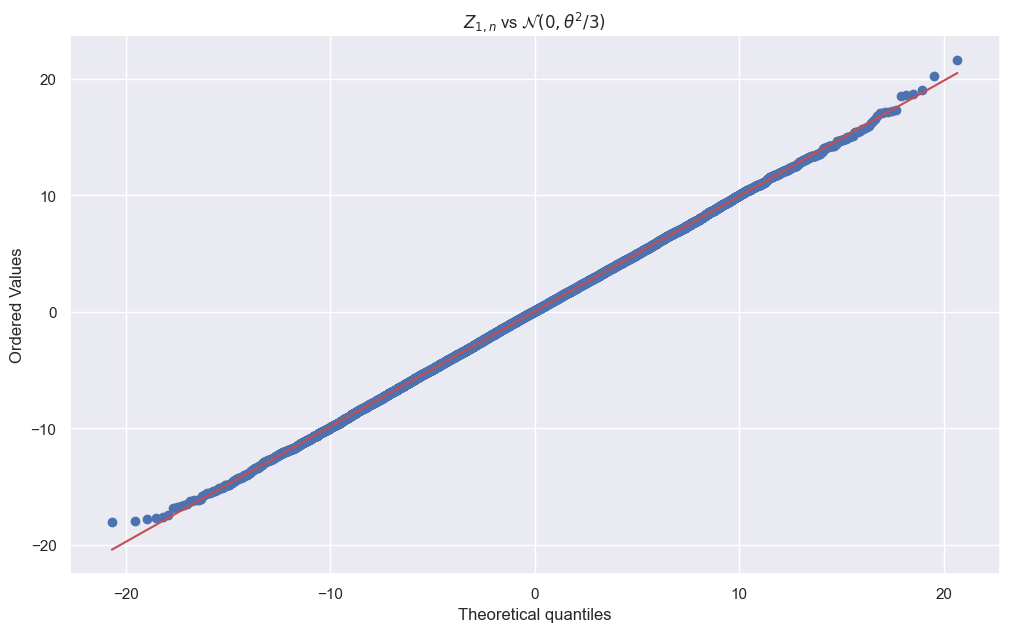

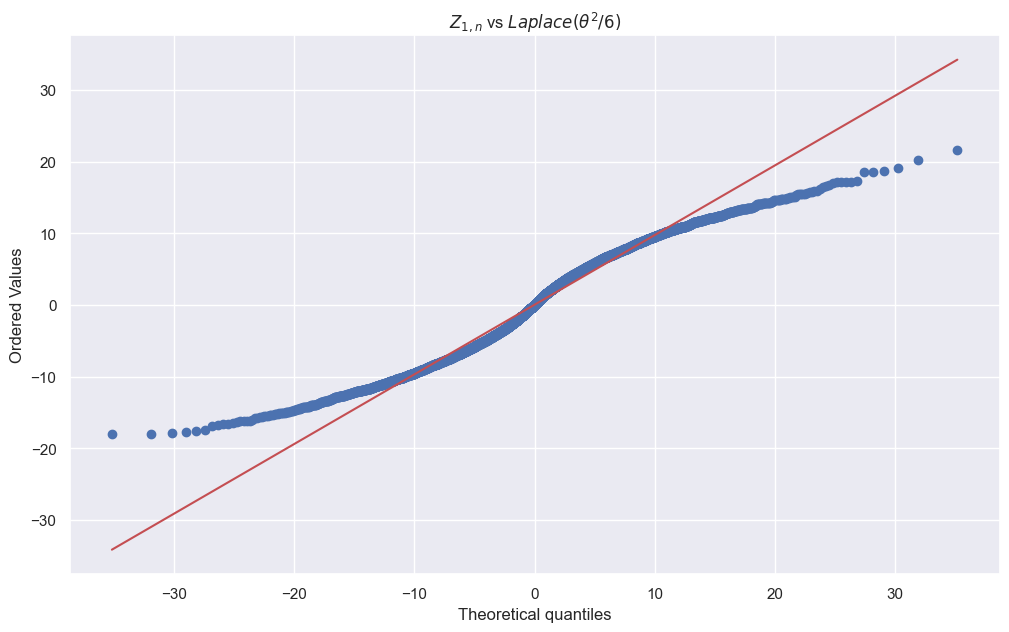

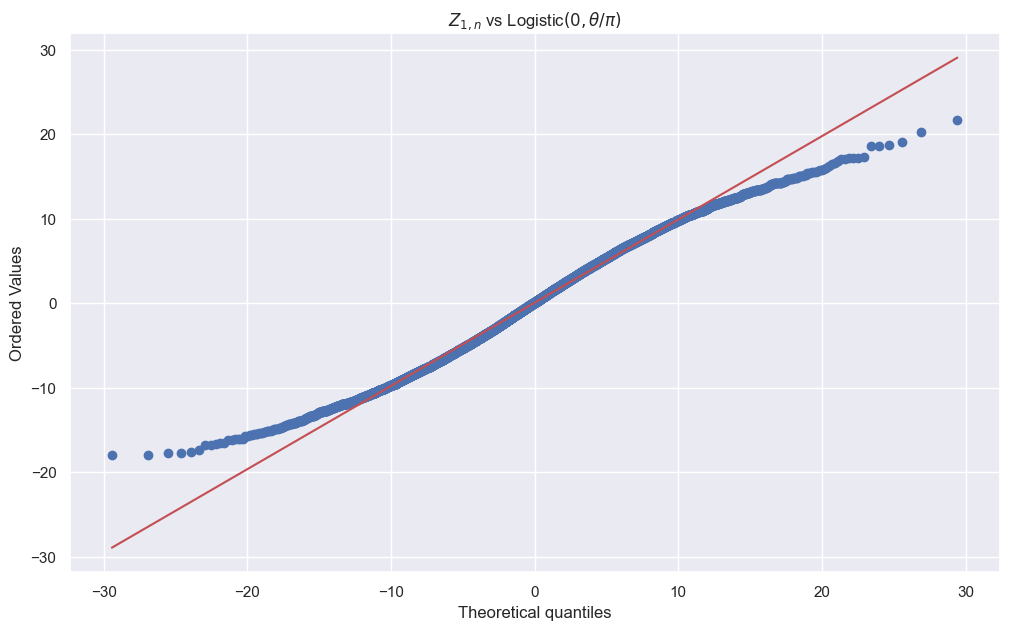

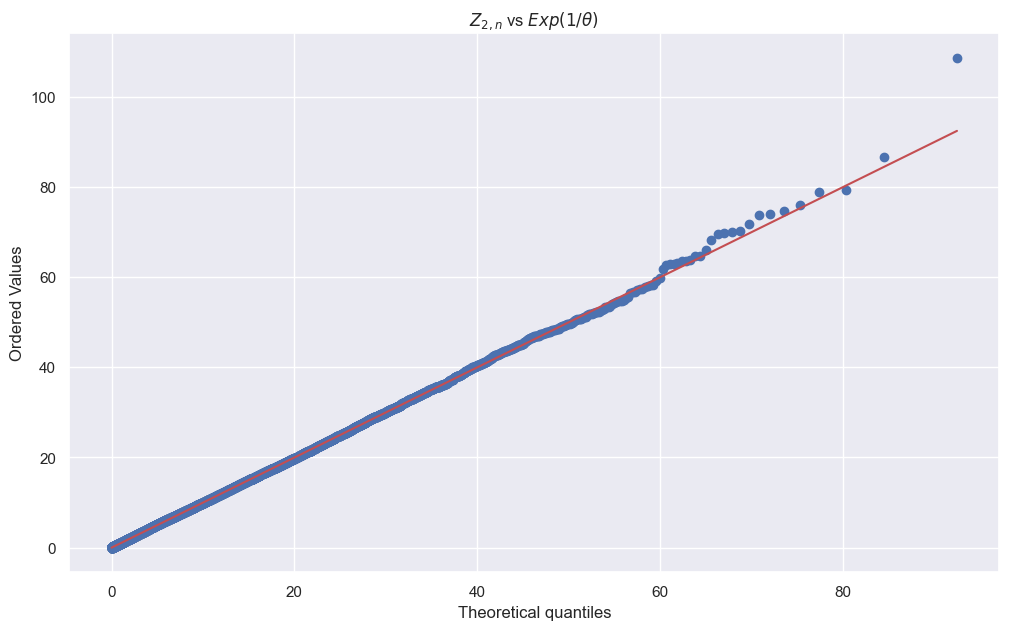

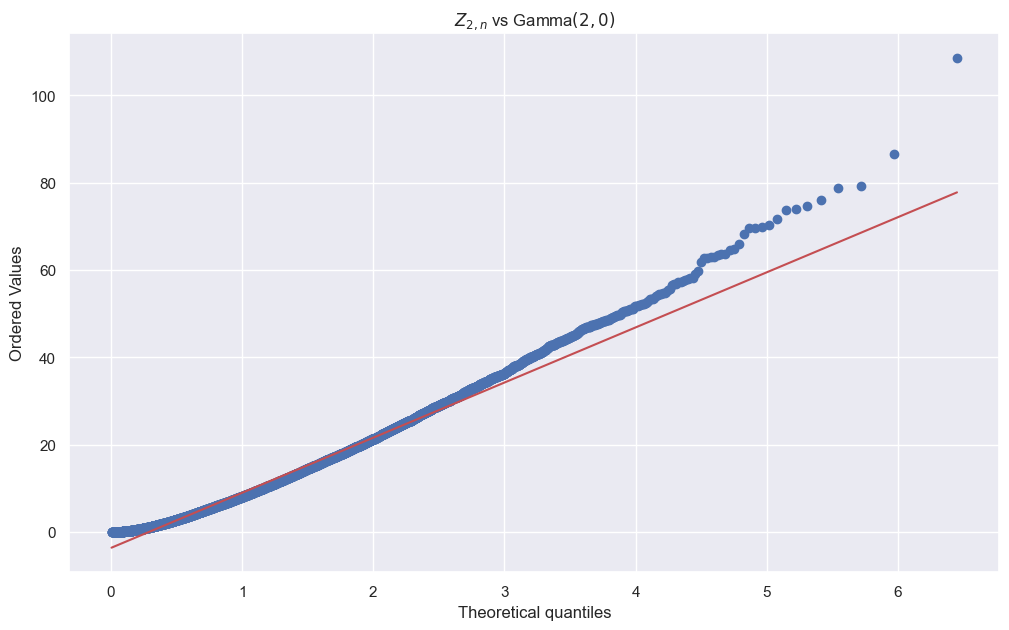

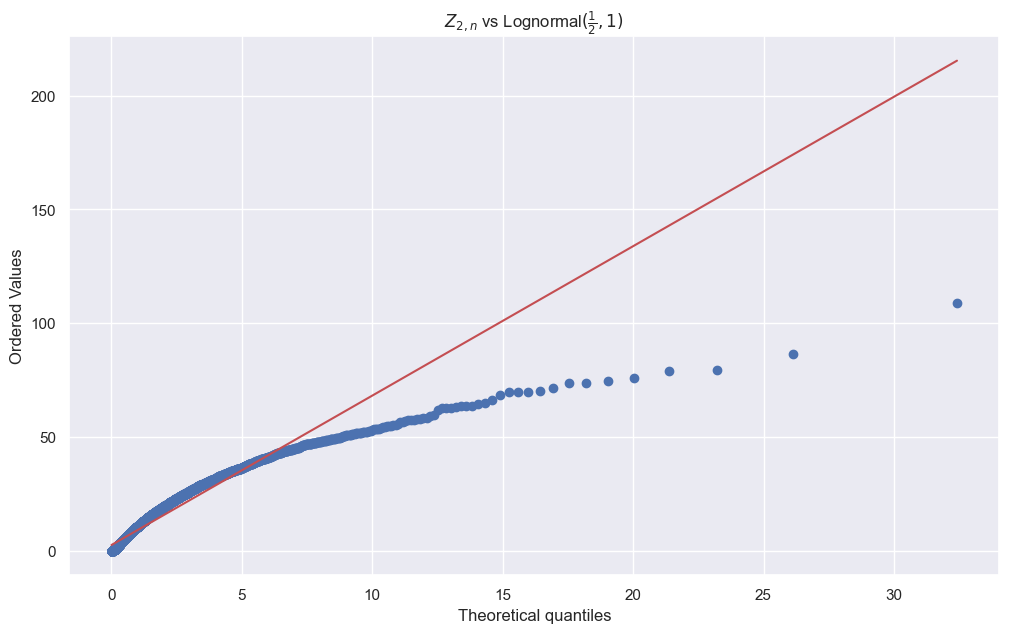

In [463]:
def draw_qqplot(z, name, distr):
    plt.figure(figsize=(12, 7))
    sps.probplot(z, dist=distr, plot=plt)
    plt.title(name)
    plt.show()


n = 400
N = 20000

samp = sps.uniform(scale=THETA).rvs(size=(N, n))

Z1 = np.sqrt(n) * (2.0 * samp.mean(axis=1) - THETA)
distr_norm = sps.norm(loc=0, scale=THETA / np.sqrt(3))
distr_laplace = sps.laplace(loc=0, scale=THETA / np.sqrt(6))
distr_logistic = sps.logistic(loc=0, scale=THETA / np.pi)

draw_qqplot(Z1, r'$Z_{1,n}$ vs $\mathcal{N}(0,\theta^2/3)$', distr_norm)
draw_qqplot(Z1, r'$Z_{1,n}$ vs $Laplace(\theta^2/6)$', distr_laplace)
draw_qqplot(Z1, r'$Z_{1,n}$ vs Logistic$(0,\theta/\pi)$', distr_logistic)

Z2 = (n + 1) * (THETA - samp.max(axis=1))  # выведено в прошлом пункте
distr_exp = sps.expon(loc=0, scale=THETA)
distr_gamma = sps.gamma(a=2.0, loc=0, scale=0.5)
distr_logn = sps.lognorm(s=1.0, loc=0, scale=np.exp(-0.5))

draw_qqplot(Z2, r'$Z_{2,n}$ vs $Exp(1/\theta)$', distr_exp)
draw_qqplot(Z2, r'$Z_{2,n}$ vs Gamma$(2,0)$', distr_gamma)
draw_qqplot(Z2, r'$Z_{2,n}$ vs Lognormal$(\frac{1}{2}, 1)$', distr_logn)

Графики (ожидаемо) подтвердили (доказанное) предположение $:)$

5. Бонусная часть (+5 баллов): Если Вы нашли семейство распределений, которое по QQ-plot соответствует выборке, то докажите строго, что $n(\theta^* - \theta)$ сходится к нему. Заметьте, что это утверждение от асимптотической нормальности отличается только заменой $\sqrt{n}$ на $n$. Такие оценки называются **сверхнормальными**. В конце доказательства поясните:

- как множитель, зависящий от $n$, связан с скоростью сходимости оценки на практике?
- лучше ли сверхнормальная оценка, чем нормальная оценка?

**Доказательство:**

Здесь удачно сложилось, что мы по сути эти шаги проделали в п.3 $:)$
- $n(\theta^*-\theta)$:

$$
n(\frac{n+1}{n}X_{(n)}-\theta)=(n+1)X_{(n)}-n\theta
$$
$$
\mathbb{P}({(n+1)X_{(n)}-n\theta \le y})
=\mathbb{P}({X_{(n)}\le \tfrac{n\theta+y}{n+1}})=
$$
$$
\text{Из ФР для } U[0,\theta]: P({X_{(n))} \le x})=(\frac{x}{\theta})^n
$$
$$
=\left(\frac{\frac{n\theta+y}{(n+1)}}{\theta}\right)^{n}
=\left(\frac{n+\frac{y}{\theta}}{n+1}\right)^{n}
=\left(1-\frac{1-\frac{y}{\theta}}{n+1}\right)^{n}
$$
$$
\text{Если $y > \theta$: не имеет смысла}
%\left(1-\frac{1-\frac{y}{\theta}}{n+1}\right)^{n} \xrightarrow{n \rightarrow \infty} 1
$$
$$
\text{Если $y \le \theta$}: \left(1-\frac{1-\frac{y}{\theta}}{n+1}\right)^{n} \xrightarrow{n \rightarrow \infty} e^{-(1-\frac{y}{\theta})}
$$
$$
\lambda:=\frac{1}{\theta} \Rightarrow e^{-(1-\frac{y}{\theta})}=e^{-\lambda(\theta-y)}
$$
$$
\text{Введём (мы это уже считали) } U:=\theta-n(\frac{n+1}{n}X_{(n)}-\theta) \xrightarrow{d} Exp(\frac{1}{\theta})=\theta \cdot Exp(1)
$$
$$
n(\frac{n+1}{n}X_{(n)}-\theta) = \theta - U \xrightarrow{d} \theta - \theta \cdot Exp(1)
$$
То же семейство, чтд.

Мы уже знаем, что оценка $\theta^*$ - лучшая, теперь мы ещё и узнали, что такие оценки называются сверхнормальными.

Первое пояснение простое (и мы обсуждали это на семинаре по обычному мастату), а второе с тонкостями, в обоих случаях буду ссылаться на 3-ю задачу:

Множитель, зависящий от $n$ напрямую влияет на скорость, чем больше множитель - тем выше скорость уменьшения функции риска. Это огромный плюс в копилку сверхнормальных оценок.
Из 3-го задание мы также можем заключить, что и график KDE у сверхнормальных будет быстрее, это же подтверждает численная проверка в этом задании. Нюанс лишь в том, что $U[0, \theta]$ - это очень классное распределение, но на практике (судя, опять же, по графикам 3-го задания) плохое распределение может сильно увести оценку, и она может начать сходиться лишь на гигантских размерах выборки, или, если распределение какие-то реальные данные, то значение вне распределения (на которое мы ориентируемся) сместят оценку очень сильно. Ещё с ассиметричными оценками работать неприятно.

6. Сделайте вывод о том, какая оценка лучше на практике. Зачем может быть важно знать точную скорость сходимости (функцию от $n$) и предельное распределение?

**Ответ:**

Та оценка, которая лучше на практике, будет зависеть от практики. При чистых красивых данных, с чистыми красивыми распределениями, почти всегда хочется брать сверхнормальное распределение по типу максимума ($\frac{n+1}{n}X_{(n)}$). Если же плохие данные и/или плохое распределение, вероятно, захочется что-то более робастное и симметричное. В идеале, конечно, держать и то и то.

Точную скорость сходимости и предельное распределение может быть важно знать если мы ограничены в ресурсах, например, можно брать меньшие размеры выборок, если функция риска убывает быстрее (об этом можно судить из скорости и/или предельного распределения).


(что-то под конец много слов стало...)

**Не забудьте перезапустить с нуля весь ноутбук перед отправкой! Habe Mut, dich deines eigenen Verstandes zu bedienen!**
